In [2]:
# Synthetic Data Generation for Software Monetization
import numpy as np
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta
import uuid
from collections import defaultdict
import os
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Global configuration parameters
class Config:
    # Dataset size parameters
    NUM_VENDORS = 50
    NUM_CUSTOMERS = 1000
    MAX_PRODUCTS_PER_VENDOR = 15
    MAX_LICENSES_PER_CUSTOMER = 8
    MAX_VARIANTS_PER_PRODUCT = 5
    
    # Time parameters
    START_DATE = datetime(2018, 1, 1)
    END_DATE = datetime(2023, 12, 31)
    MAX_CONTRACT_DURATION_DAYS = 365 * 3  # 3 years
    
    # Output paths
    OUTPUT_DIR = "./software_monetization_data"
    VENDORS_FILE = "vendors.csv"
    CUSTOMERS_FILE = "customers.csv"
    PRODUCTS_FILE = "products.csv"
    LICENSES_FILE = "licenses.csv"
    USAGE_FILE = "usage_metrics.csv"
    TRANSACTIONS_FILE = "transactions.csv"
    RENEWALS_FILE = "renewals_history.csv"
    
    # Probability distributions
    VENDOR_SIZE_DISTRIBUTION = [0.6, 0.3, 0.1]  # Small, Medium, Large
    INDUSTRY_DISTRIBUTION = {
        'Technology': 0.25,
        'Finance': 0.2,
        'Healthcare': 0.15,
        'Manufacturing': 0.15,
        'Retail': 0.1,
        'Education': 0.08,
        'Government': 0.07
    }
    COMPANY_SIZE_DISTRIBUTION = {
        'Small (<100)': 0.5,
        'Medium (100-1000)': 0.35,
        'Large (>1000)': 0.15
    }
    
    # Random seed for reproducibility
    RANDOM_SEED = 42

# Set random seeds for reproducibility
np.random.seed(Config.RANDOM_SEED)
random.seed(Config.RANDOM_SEED)
Faker.seed(Config.RANDOM_SEED)
fake = Faker()

# Helper functions
def random_date(start, end):
    """Generate a random datetime between two datetime objects."""
    return start + timedelta(
        seconds=random.randint(0, int((end - start).total_seconds())))

def generate_vendor_size():
    """Generate vendor size based on configured distribution."""
    return random.choices(
        ['Small', 'Medium', 'Large'],
        weights=Config.VENDOR_SIZE_DISTRIBUTION,
        k=1
    )[0]

def generate_industry():
    """Generate industry type based on configured distribution."""
    return random.choices(
        list(Config.INDUSTRY_DISTRIBUTION.keys()),
        weights=list(Config.INDUSTRY_DISTRIBUTION.values()),
        k=1
    )[0]

def generate_company_size():
    """Generate company size based on configured distribution."""
    return random.choices(
        list(Config.COMPANY_SIZE_DISTRIBUTION.keys()),
        weights=list(Config.COMPANY_SIZE_DISTRIBUTION.values()),
        k=1
    )[0]

def generate_product_features():
    """Generate random product features with varying complexity."""
    base_features = ['Analytics', 'Security', 'API Access', 'Cloud Storage', 
                    'Multi-user', 'Mobile', 'Desktop', 'Web', 'AI/ML', 'IoT']
    
    # Select 2-5 random features
    num_features = random.randint(2, 5)
    selected = random.sample(base_features, num_features)
    
    # Add some random specifications
    specs = {
        'Analytics': ['Basic', 'Advanced', 'Real-time', 'Predictive'],
        'Security': ['Standard', 'Enterprise', 'GDPR Compliant', 'HIPAA Compliant'],
        'API Access': ['Limited', 'Full', 'Premium'],
        'Cloud Storage': ['1TB', '5TB', '10TB', 'Unlimited']
    }
    
    enhanced_features = []
    for feature in selected:
        if feature in specs:
            enhanced_features.append(f"{feature} ({random.choice(specs[feature])})")
        else:
            enhanced_features.append(feature)
    
    return ", ".join(enhanced_features)

def generate_subscription_type():
    """Generate different subscription/licensing models."""
    types = [
        'Perpetual License',
        'Annual Subscription',
        'Monthly Subscription',
        'Pay-as-you-go',
        'Floating License',
        'Concurrent User License',
        'Site License',
        'Enterprise License'
    ]
    return random.choice(types)

def generate_license_metrics(subscription_type):
    """Generate realistic license metrics based on subscription type."""
    metrics = {}
    
    # Common metrics
    metrics['quantities_purchased'] = random.randint(1, 1000)
    metrics['quantities_activated'] = min(
        metrics['quantities_purchased'],
        random.randint(1, metrics['quantities_purchased'])
    )
    metrics['percentage_deployed'] = round(
        random.uniform(0.1, 1.0) * metrics['quantities_activated'] / metrics['quantities_purchased'],
        2
    )
    
    # Time-based metrics
    metrics['days_since_last_purchase'] = random.randint(1, 365)
    metrics['days_since_last_activated'] = random.randint(1, metrics['days_since_last_purchase'])
    
    # Gap metrics
    metrics['avg_gap_purchase_days'] = random.randint(7, 90)
    metrics['avg_gap_activated_days'] = random.randint(7, metrics['avg_gap_purchase_days'])
    
    # Trend metrics
    trends = ['Upward', 'Downward', 'Flat', 'Fluctuating']
    metrics['trend_purchased'] = random.choice(trends)
    metrics['trend_activated'] = random.choice(trends)
    metrics['trend_deployed'] = random.choice(trends)
    
    # Environment
    environments = ['Production', 'Test', 'Development', 'Staging']
    metrics['environment'] = random.choices(
        environments,
        weights=[0.7, 0.15, 0.1, 0.05],
        k=1
    )[0]
    
    # First purchase/activation
    metrics['days_since_first_purchase'] = metrics['days_since_last_purchase'] + random.randint(30, 365*3)
    metrics['days_since_first_activation'] = min(
        metrics['days_since_first_purchase'],
        metrics['days_since_first_purchase'] - random.randint(1, 30)
    )
    
    # Purchase to activation gap
    metrics['avg_gap_purchase_to_activation'] = random.randint(1, 14)
    
    # Frequency and recency
    metrics['frequency_product_purchase'] = random.choice(['Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly'])
    metrics['recency_product_purchase'] = random.choice(['Recent', 'Moderate', 'Long'])
    
    # Relative metrics
    metrics['relative_products_purchased'] = round(random.uniform(0.1, 1.0), 2)
    metrics['relative_purchase_qty'] = round(random.uniform(0.1, 1.0), 2)
    metrics['relative_activation_qty'] = round(random.uniform(0.1, 1.0), 2)
    metrics['relative_activation_pct'] = round(random.uniform(0.1, 1.0), 2)
    
    # Variant metrics
    num_variants = random.randint(1, Config.MAX_VARIANTS_PER_PRODUCT)
    variants = [f"Variant_{i}" for i in range(1, num_variants+1)]
    metrics['variants_activated'] = ", ".join(random.sample(variants, random.randint(1, num_variants)))
    metrics['relative_variant_pct'] = round(random.uniform(0.1, 1.0), 2)
    metrics['relative_variant_qty'] = round(random.uniform(0.1, 1.0), 2)
    
    # Subscription period
    if 'Annual' in subscription_type:
        metrics['subscription_period'] = 365
    elif 'Monthly' in subscription_type:
        metrics['subscription_period'] = 30
    elif 'Perpetual' in subscription_type:
        metrics['subscription_period'] = 365*10  # 10 years for perpetual
    else:
        metrics['subscription_period'] = random.randint(30, 365)
    
    return metrics

def generate_contract_value(product_id, quantities_purchased, subscription_period):
    """Generate realistic contract value based on product and license details."""
    # Base price per unit (simulated)
    base_price = {
        'P001': 1000, 'P002': 500, 'P003': 1500, 'P004': 200, 'P005': 750,
        'P006': 3000, 'P007': 250, 'P008': 1200, 'P009': 800, 'P010': 400
    }.get(product_id[:4], 500)  # Default to $500 if not in our base set
    
    # Adjust for subscription period (longer = discount)
    period_factor = 1.0
    if subscription_period > 365:
        period_factor = 0.8  # 20% discount for multi-year
    elif subscription_period > 30:
        period_factor = 0.9  # 10% discount for annual
    
    # Volume discount
    volume_factor = 1.0
    if quantities_purchased > 500:
        volume_factor = 0.7
    elif quantities_purchased > 100:
        volume_factor = 0.8
    elif quantities_purchased > 50:
        volume_factor = 0.9
    
    # Calculate final value
    return round(base_price * quantities_purchased * period_factor * volume_factor, 2)

def generate_renewal_history(license_id, start_date, end_date, subscription_period):
    """Generate renewal history for a license."""
    renewals = []
    current_date = start_date
    renewal_count = 0
    
    # Always include the initial purchase
    renewals.append({
        'renewal_id': f"{license_id}_INITIAL",
        'license_id': license_id,
        'renewal_date': current_date,
        'renewal_type': 'Initial Purchase',
        'renewal_status': 'Completed',
        'renewal_amount': 0,  # Will be filled later
        'days_before_expiry': 0
    })
    
    # Generate possible renewals
    while current_date < end_date:
        renewal_count += 1
        # Decide if they will renew (80% chance)
        if random.random() < 0.8:
            # Renew between 30 days before and day of expiry
            renewal_date = current_date + timedelta(days=subscription_period - random.randint(0, 30))
            renewals.append({
                'renewal_id': f"{license_id}_R{renewal_count}",
                'license_id': license_id,
                'renewal_date': renewal_date,
                'renewal_type': 'Renewal',
                'renewal_status': 'Completed',
                'renewal_amount': 0,  # Will be filled later
                'days_before_expiry': random.randint(0, 30)
            })
            current_date = renewal_date
        else:
            break
    
    return renewals

# Generate vendors data
def generate_vendors():
    vendors = []
    vendor_sizes = defaultdict(int)
    
    for i in range(1, Config.NUM_VENDORS + 1):
        vendor_id = f"V{i:03d}"
        vendor_size = generate_vendor_size()
        vendor_sizes[vendor_size] += 1
        
        vendors.append({
            'vendor_id': vendor_id,
            'vendor_name': fake.company(),
            'vendor_size': vendor_size,
            'founding_year': random.randint(1990, 2020),
            'headquarters': fake.city(),
            'primary_industry': generate_industry(),
            'total_products': random.randint(1, Config.MAX_PRODUCTS_PER_VENDOR),
            'active_customers': 0,  # Will be updated later
            'total_revenue': 0  # Will be updated later
        })
    
    return pd.DataFrame(vendors)

# Generate customers data
def generate_customers():
    customers = []
    
    for i in range(1, Config.NUM_CUSTOMERS + 1):
        customer_id = f"C{i:04d}"
        customers.append({
            'customer_id': customer_id,
            'company_name': fake.company(),
            'industry': generate_industry(),
            'company_size': generate_company_size(),
            'location': fake.country(),
            'years_in_business': random.randint(1, 50),
            'customer_segment': random.choice(['Premium', 'Standard', 'Basic']),
            'first_purchase_date': random_date(Config.START_DATE, Config.END_DATE),
            'total_products_used': 0,  # Will be updated later
            'total_spend': 0  # Will be updated later
        })
    
    return pd.DataFrame(customers)

# Generate products data
def generate_products(vendors_df):
    products = []
    product_counter = 1
    
    for _, vendor in vendors_df.iterrows():
        num_products = vendor['total_products']
        
        for i in range(1, num_products + 1):
            product_id = f"P{product_counter:03d}"
            launch_date = random_date(
                datetime(vendor['founding_year'], 1, 1),
                Config.END_DATE - timedelta(days=365)
            )
            
            products.append({
                'product_id': product_id,
                'vendor_id': vendor['vendor_id'],
                'product_name': fake.catch_phrase(),
                'product_category': random.choice([
                    'Analytics', 'Security', 'Development', 'Productivity', 
                    'Collaboration', 'Infrastructure', 'Database', 'AI/ML'
                ]),
                'product_features': generate_product_features(),
                'launch_date': launch_date,
                'current_version': f"{random.randint(1, 5)}.{random.randint(0, 9)}.{random.randint(0, 9)}",
                'is_saas': random.choice([True, False]),
                'has_free_tier': random.choice([True, False])
            })
            product_counter += 1
    
    return pd.DataFrame(products)

# Generate licenses data
def generate_licenses(customers_df, products_df, vendors_df):
    licenses = []
    usage_metrics = []
    transactions = []
    renewals = []
    
    # Update structures to track customer/vendor activity
    customer_activity = defaultdict(int)
    vendor_activity = defaultdict(int)
    vendor_revenue = defaultdict(float)
    
    # Assign products to customers
    for _, customer in customers_df.iterrows():
        num_licenses = random.randint(1, Config.MAX_LICENSES_PER_CUSTOMER)
        licensed_products = random.sample(
            list(products_df['product_id']), 
            min(num_licenses, len(products_df))
        )
        
        for product_id in licensed_products:
            # Get product and vendor info
            product = products_df[products_df['product_id'] == product_id].iloc[0]
            vendor_id = product['vendor_id']
            
            # Generate license details
            license_id = f"L{len(licenses) + 1:05d}"
            subscription_type = generate_subscription_type()
            start_date = random_date(
                max(customer['first_purchase_date'], product['launch_date']),
                Config.END_DATE - timedelta(days=365)
            )
            end_date = start_date + timedelta(days=random.randint(30, Config.MAX_CONTRACT_DURATION_DAYS))
            
            # Generate license metrics
            metrics = generate_license_metrics(subscription_type)
            
            # Generate contract value
            contract_value = generate_contract_value(
                product_id,
                metrics['quantities_purchased'],
                metrics['subscription_period']
            )
            
            # Create license record
            licenses.append({
                'license_id': license_id,
                'customer_id': customer['customer_id'],
                'product_id': product_id,
                'vendor_id': vendor_id,
                'subscription_type': subscription_type,
                'start_date': start_date,
                'end_date': end_date,
                'is_active': end_date > Config.END_DATE,
                'auto_renew': random.choice([True, False]),
                'contract_value': contract_value
            })
            
            # Create usage metrics record
            usage_metrics.append({
                'license_id': license_id,
                **metrics
            })
            
            # Create transaction record for initial purchase
            transactions.append({
                'transaction_id': f"T{len(transactions) + 1:06d}",
                'license_id': license_id,
                'transaction_date': start_date,
                'transaction_type': 'Initial Purchase',
                'amount': contract_value,
                'payment_method': random.choice(['Credit Card', 'Invoice', 'Bank Transfer']),
                'status': 'Completed'
            })
            
            # Generate renewal history
            renewal_history = generate_renewal_history(
                license_id, start_date, end_date, metrics['subscription_period'])
            
            for renewal in renewal_history:
                # Set renewal amount (80-120% of original contract value)
                renewal_amount = round(
                    contract_value * random.uniform(0.8, 1.2),
                    2
                )
                renewal['renewal_amount'] = renewal_amount
                renewals.append(renewal)
                
                # Add renewal transaction
                transactions.append({
                    'transaction_id': f"T{len(transactions) + 1:06d}",
                    'license_id': license_id,
                    'transaction_date': renewal['renewal_date'],
                    'transaction_type': 'Renewal',
                    'amount': renewal_amount,
                    'payment_method': random.choice(['Credit Card', 'Invoice', 'Bank Transfer']),
                    'status': renewal['renewal_status']
                })
            
            # Update activity counters
            customer_activity[customer['customer_id']] += 1
            vendor_activity[vendor_id] += 1
            vendor_revenue[vendor_id] += contract_value
    
    # Update customer and vendor dataframes
    customers_df['total_products_used'] = customers_df['customer_id'].map(customer_activity)
    vendors_df['active_customers'] = vendors_df['vendor_id'].map(vendor_activity)
    vendors_df['total_revenue'] = vendors_df['vendor_id'].map(vendor_revenue)
    
    return (
        pd.DataFrame(licenses),
        pd.DataFrame(usage_metrics),
        pd.DataFrame(transactions),
        pd.DataFrame(renewals)
    )

# Generate aggregated datasets
def generate_aggregated_data(vendors_df, customers_df, products_df, licenses_df, transactions_df):
    # Vendor performance summary
    vendor_performance = licenses_df.groupby('vendor_id').agg({
        'license_id': 'count',
        'contract_value': 'sum',
        'is_active': 'sum'
    }).reset_index()
    vendor_performance = vendor_performance.merge(
        vendors_df[['vendor_id', 'vendor_name', 'vendor_size']],
        on='vendor_id'
    )
    vendor_performance.columns = [
        'vendor_id', 'total_licenses', 'total_revenue', 'active_licenses',
        'vendor_name', 'vendor_size'
    ]
    vendor_performance['renewal_rate'] = round(
        vendor_performance['active_licenses'] / vendor_performance['total_licenses'],
        2
    )
    
    # Customer spending summary
    customer_spending = licenses_df.groupby('customer_id').agg({
        'license_id': 'count',
        'contract_value': 'sum',
        'is_active': 'sum'
    }).reset_index()
    customer_spending = customer_spending.merge(
        customers_df[['customer_id', 'company_name', 'company_size', 'industry']],
        on='customer_id'
    )
    customer_spending.columns = [
        'customer_id', 'total_licenses', 'total_spend', 'active_licenses',
        'company_name', 'company_size', 'industry'
    ]
    
    # Product performance
    product_performance = licenses_df.groupby('product_id').agg({
        'license_id': 'count',
        'contract_value': 'sum',
        'is_active': 'sum'
    }).reset_index()
    product_performance = product_performance.merge(
        products_df[['product_id', 'product_name', 'product_category', 'vendor_id']],
        on='product_id'
    )
    product_performance.columns = [
        'product_id', 'total_licenses', 'total_revenue', 'active_licenses',
        'product_name', 'product_category', 'vendor_id'
    ]
    
    return vendor_performance, customer_spending, product_performance

# Main data generation function
def generate_all_data():
    # Create output directory if it doesn't exist
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    
    print("Generating vendors data...")
    vendors_df = generate_vendors()
    
    print("Generating customers data...")
    customers_df = generate_customers()
    
    print("Generating products data...")
    products_df = generate_products(vendors_df)
    
    print("Generating licenses and related data...")
    licenses_df, usage_metrics_df, transactions_df, renewals_df = generate_licenses(
        customers_df, products_df, vendors_df
    )
    
    print("Generating aggregated datasets...")
    vendor_perf_df, customer_spend_df, product_perf_df = generate_aggregated_data(
        vendors_df, customers_df, products_df, licenses_df, transactions_df
    )
    
    # Save all datasets to CSV
    print("Saving datasets to CSV files...")
    vendors_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.VENDORS_FILE), index=False)
    customers_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.CUSTOMERS_FILE), index=False)
    products_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.PRODUCTS_FILE), index=False)
    licenses_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.LICENSES_FILE), index=False)
    usage_metrics_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.USAGE_FILE), index=False)
    transactions_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.TRANSACTIONS_FILE), index=False)
    renewals_df.to_csv(os.path.join(Config.OUTPUT_DIR, Config.RENEWALS_FILE), index=False)
    
    # Save aggregated datasets
    vendor_perf_df.to_csv(os.path.join(Config.OUTPUT_DIR, "vendor_performance.csv"), index=False)
    customer_spend_df.to_csv(os.path.join(Config.OUTPUT_DIR, "customer_spending.csv"), index=False)
    product_perf_df.to_csv(os.path.join(Config.OUTPUT_DIR, "product_performance.csv"), index=False)
    
    print("Data generation complete!")
    
    return {
        'vendors': vendors_df,
        'customers': customers_df,
        'products': products_df,
        'licenses': licenses_df,
        'usage_metrics': usage_metrics_df,
        'transactions': transactions_df,
        'renewals': renewals_df,
        'vendor_performance': vendor_perf_df,
        'customer_spending': customer_spend_df,
        'product_performance': product_perf_df
    }

# Execute the data generation
if __name__ == "__main__":
    data = generate_all_data()

Generating vendors data...
Generating customers data...
Generating products data...
Generating licenses and related data...


ValueError: empty range in randrange(0, -23570987)

In [12]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from faker import Faker
import json
import os
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')
from calendar import monthrange
# ==================== GLOBAL CONFIGURATION ====================
# Dataset Size Configuration
NUM_VENDORS = 50
NUM_CUSTOMERS = 500
NUM_PRODUCTS_PER_VENDOR = {'small': (2, 5), 'medium': (5, 10), 'large': (10, 20)}
NUM_LICENSES_PER_CUSTOMER = {'low': (1, 3), 'medium': (3, 8), 'high': (8, 15)}

# Time Configuration
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2024, 12, 31)
HISTORICAL_YEARS = 5

# Business Configuration
VENDOR_SIZE_DISTRIBUTION = {'small': 0.6, 'medium': 0.3, 'large': 0.1}
CUSTOMER_SIZE_DISTRIBUTION = {'small': 0.5, 'medium': 0.3, 'large': 0.2}
CHURN_RATE = 0.15
RENEWAL_RATE = 0.85

# Product Configuration
PRODUCT_CATEGORIES = ['Analytics', 'Security', 'Productivity', 'Communication', 'Database', 
                     'Development', 'Marketing', 'HR', 'Finance', 'Operations']
DEPLOYMENT_TYPES = ['Production', 'Development', 'Test']
DEPLOYMENT_DISTRIBUTION = {'Production': 0.7, 'Development': 0.2, 'Test': 0.1}

# License Configuration
LICENSE_TYPES = ['Per User', 'Per Device', 'Per Hour', 'Per Transaction', 'Unlimited', 'Per GB']
SUBSCRIPTION_PERIODS = [30, 90, 365, 730, 1095]  # days
SUBSCRIPTION_DISTRIBUTION = {30: 0.1, 90: 0.2, 365: 0.5, 730: 0.15, 1095: 0.05}

# Data Quality Configuration
MISSING_DATA_RATE = 0.02
ACTIVATION_RATE_MEAN = 0.85
DEPLOYMENT_RATE_MEAN = 0.75

# Output Configuration
OUTPUT_DIR = 'software_monetization_dataset'

# ==================== UTILITY FUNCTIONS ====================
fake = Faker()
np.random.seed(42)
random.seed(42)

def safe_date_between(start, end):
    """Return a valid random date between start and end, even if start > end."""
    if start > end:
        return end
    return fake.date_between(start_date=start, end_date=end)


def add_month(current_date):
    """Safely adds one month to a datetime object."""
    year = current_date.year + (current_date.month // 12)
    month = current_date.month % 12 + 1
    day = min(current_date.day, monthrange(year, month)[1])  # Avoid Feb 30, etc.
    return datetime(year, month, day)

def weighted_choice(choices: Dict) -> str:
    """Select item based on weights"""
    items = list(choices.keys())
    weights = list(choices.values())
    return np.random.choice(items, p=weights)

def generate_date_range(start: datetime, end: datetime) -> datetime:
    """Generate random date between start and end"""
    time_delta = end - start
    random_days = np.random.randint(0, time_delta.days)
    return start + timedelta(days=random_days)

def calculate_trend(values: List[float]) -> str:
    """Calculate trend direction from values"""
    if len(values) < 2:
        return 'Flat'
    
    slope = np.polyfit(range(len(values)), values, 1)[0]
    if slope > 0.1:
        return 'Upward'
    elif slope < -0.1:
        return 'Downward'
    else:
        return 'Flat'

def introduce_missing_data(df: pd.DataFrame, rate: float = MISSING_DATA_RATE) -> pd.DataFrame:
    """Introduce missing data randomly"""
    mask = np.random.random(df.shape) < rate
    df_copy = df.copy()
    df_copy = df_copy.mask(mask)
    return df_copy

# ==================== DATASET GENERATORS ====================

class SoftwareMonetizationDataGenerator:
    def __init__(self):
        self.vendors = []
        self.customers = []
        self.products = []
        self.licenses = []
        self.usage_data = []
        
    def generate_vendors(self) -> pd.DataFrame:
        """Generate vendor dataset"""
        vendors = []
        
        for i in range(NUM_VENDORS):
            vendor_size = weighted_choice(VENDOR_SIZE_DISTRIBUTION)
            
            # Revenue ranges based on company size
            if vendor_size == 'small':
                revenue_range = (100000, 1000000)
                employee_range = (5, 50)
            elif vendor_size == 'medium':
                revenue_range = (1000000, 10000000)
                employee_range = (50, 500)
            else:  # large
                revenue_range = (10000000, 100000000)
                employee_range = (500, 5000)
            
            vendor = {
                'Vendor_ID': f'V{i+1:04d}',
                'Vendor_Name': fake.company(),
                'Industry': fake.random_element(['Software', 'Technology', 'Enterprise Solutions', 'Cloud Services']),
                'Founded_Year': fake.random_int(min=1990, max=2020),
                'Headquarters': fake.city(),
                'Country': fake.country(),
                'Company_Size': vendor_size,
                'Employee_Count': fake.random_int(min=employee_range[0], max=employee_range[1]),
                'Annual_Revenue': fake.random_int(min=revenue_range[0], max=revenue_range[1]),
                'Total_Products': fake.random_int(min=NUM_PRODUCTS_PER_VENDOR[vendor_size][0], 
                                                max=NUM_PRODUCTS_PER_VENDOR[vendor_size][1]),
                'Total_Customers': 0,  # Will be updated later
                'Market_Focus': fake.random_element(['B2B', 'B2C', 'B2B2C']),
                'Support_Model': fake.random_element(['24/7', 'Business Hours', 'Community']),
                'Deployment_Model': fake.random_element(['Cloud', 'On-Premise', 'Hybrid']),
                'Certification': fake.random_element(['ISO27001', 'SOC2', 'GDPR', 'HIPAA', 'None'])
            }
            vendors.append(vendor)
        
        self.vendors = pd.DataFrame(vendors)
        return self.vendors
    
    def generate_customers(self) -> pd.DataFrame:
        """Generate customer dataset"""
        customers = []
        
        industries = ['Manufacturing', 'Retail', 'Technology', 'Healthcare', 'Finance', 
                     'Education', 'Government', 'Energy', 'Transportation', 'Media']
        
        for i in range(NUM_CUSTOMERS):
            customer_size = weighted_choice(CUSTOMER_SIZE_DISTRIBUTION)
            
            if customer_size == 'small':
                employee_range = (10, 100)
                revenue_range = (500000, 5000000)
            elif customer_size == 'medium':
                employee_range = (100, 1000)
                revenue_range = (5000000, 50000000)
            else:  # large
                employee_range = (1000, 10000)
                revenue_range = (50000000, 500000000)
            
            customer = {
                'Customer_ID': f'C{i+1:05d}',
                'Company_Name': fake.company(),
                'Industry_Type': fake.random_element(industries),
                'Company_Size': customer_size,
                'Employee_Count': fake.random_int(min=employee_range[0], max=employee_range[1]),
                'Annual_Revenue': fake.random_int(min=revenue_range[0], max=revenue_range[1]),
                'Location': fake.city(),
                'State': fake.state(),
                'Country': fake.country(),
                'Years_in_Business': fake.random_int(min=1, max=50),
                'Segment': fake.random_element(['Premium', 'Standard', 'Basic']),
                'IT_Budget': fake.random_int(min=50000, max=5000000),
                'Decision_Maker': fake.name(),
                'Contact_Email': fake.email(),
                'Registration_Date': fake.date_between(start_date=START_DATE, end_date=END_DATE)
            }
            customers.append(customer)
        
        self.customers = pd.DataFrame(customers)
        return self.customers
    
    def generate_products(self) -> pd.DataFrame:
        """Generate product dataset"""
        products = []
        product_id = 1
        
        for _, vendor in self.vendors.iterrows():
            num_products = vendor['Total_Products']
            
            for j in range(num_products):
                category = fake.random_element(PRODUCT_CATEGORIES)
                
                product = {
                    'Product_ID': f'P{product_id:05d}',
                    'Vendor_ID': vendor['Vendor_ID'],
                    'Product_Name': f"{category} {fake.word().title()} {fake.random_element(['Pro', 'Enterprise', 'Basic', 'Premium'])}",
                    'Product_Category': category,
                    'Launch_Date': fake.date_between(start_date=START_DATE, end_date=END_DATE),
                    'License_Type': fake.random_element(LICENSE_TYPES),
                    'Base_Price': fake.random_int(min=10, max=1000),
                    'Currency': 'USD',
                    'Product_Features': fake.random_int(min=3, max=15),
                    'Version': f"{fake.random_int(min=1, max=5)}.{fake.random_int(min=0, max=9)}.{fake.random_int(min=0, max=9)}",
                    'Maturity': fake.random_element(['Beta', 'Stable', 'Legacy']),
                    'Support_Level': fake.random_element(['Basic', 'Premium', 'Enterprise']),
                    'Documentation_Quality': fake.random_element(['Poor', 'Good', 'Excellent']),
                    'API_Available': fake.boolean(),
                    'Integration_Complexity': fake.random_element(['Low', 'Medium', 'High'])
                }
                products.append(product)
                product_id += 1
        
        self.products = pd.DataFrame(products)
        return self.products
    
    def generate_licenses(self) -> pd.DataFrame:
        """Generate comprehensive license dataset with all required features"""
        licenses = []
        license_id = 1
        
        for _, customer in self.customers.iterrows():
            # Determine number of licenses for this customer
            license_intensity = weighted_choice({'low': 0.6, 'medium': 0.3, 'high': 0.1})
            num_licenses = fake.random_int(
                min=NUM_LICENSES_PER_CUSTOMER[license_intensity][0],
                max=NUM_LICENSES_PER_CUSTOMER[license_intensity][1]
            )
            
            # Select random vendors for this customer
            available_vendors = self.vendors.sample(n=min(num_licenses, len(self.vendors)))
            
            for _, vendor in available_vendors.iterrows():
                # Select random products from this vendor
                vendor_products = self.products[self.products['Vendor_ID'] == vendor['Vendor_ID']]
                if len(vendor_products) == 0:
                    continue
                
                num_products = fake.random_int(min=1, max=min(3, len(vendor_products)))
                selected_products = vendor_products.sample(n=num_products)
                
                for _, product in selected_products.iterrows():
                    # Generate purchase history
                    purchase_dates = []
                    activation_dates = []
                    
                    # Generate multiple purchase events
                    num_purchases = fake.random_int(min=1, max=5)
                    current_date = generate_date_range(START_DATE, END_DATE)
                    
                    for purchase_num in range(num_purchases):
                        purchase_dates.append(current_date)
                        
                        # Activation date (usually within 30 days of purchase)
                        activation_delay = fake.random_int(min=0, max=30)
                        activation_date = current_date + timedelta(days=activation_delay)
                        activation_dates.append(activation_date)
                        
                        # Next purchase date
                        if purchase_num < num_purchases - 1:
                            days_gap = fake.random_int(min=30, max=400)
                            current_date = current_date + timedelta(days=days_gap)
                    
                    # Calculate quantities
                    quantities_purchased = [fake.random_int(min=1, max=100) for _ in purchase_dates]
                    quantities_activated = [min(qty, int(qty * np.random.normal(ACTIVATION_RATE_MEAN, 0.1))) 
                                          for qty in quantities_purchased]
                    quantities_deployed = [min(qty_act, int(qty_act * np.random.normal(DEPLOYMENT_RATE_MEAN, 0.1))) 
                                         for qty_act in quantities_activated]
                    
                    # Current totals
                    total_purchased = sum(quantities_purchased)
                    total_activated = sum(quantities_activated)
                    total_deployed = sum(quantities_deployed)
                    
                    # Calculate derived features
                    days_since_first_purchase = (END_DATE - min(purchase_dates)).days
                    days_since_last_purchase = (END_DATE - max(purchase_dates)).days
                    days_since_first_activation = (END_DATE - min(activation_dates)).days
                    days_since_last_activation = (END_DATE - max(activation_dates)).days
                    
                    # Calculate gaps
                    purchase_gaps = [(purchase_dates[i+1] - purchase_dates[i]).days 
                                   for i in range(len(purchase_dates)-1)]
                    activation_gaps = [(activation_dates[i+1] - activation_dates[i]).days 
                                     for i in range(len(activation_dates)-1)]
                    purchase_to_activation_gaps = [(activation_dates[i] - purchase_dates[i]).days 
                                                 for i in range(len(purchase_dates))]
                    
                    avg_purchase_gap = np.mean(purchase_gaps) if purchase_gaps else 0
                    avg_activation_gap = np.mean(activation_gaps) if activation_gaps else 0
                    avg_purchase_to_activation_gap = np.mean(purchase_to_activation_gaps)
                    
                    # Calculate trends
                    purchase_trend = calculate_trend(quantities_purchased)
                    activation_trend = calculate_trend(quantities_activated)
                    deployment_trend = calculate_trend(quantities_deployed)
                    
                    # Generate variants
                    num_variants = fake.random_int(min=1, max=5)
                    variants = [f"V{i+1}" for i in range(num_variants)]
                    activated_variants = fake.random_elements(variants, length=fake.random_int(min=1, max=num_variants))
                    
                    license = {
                        'License_ID': f'L{license_id:06d}',
                        'Customer_ID': customer['Customer_ID'],
                        'Vendor_ID': vendor['Vendor_ID'],
                        'Product_ID': product['Product_ID'],
                        
                        # Core required features (as per original specification)
                        'Number_of_quantities_purchased': total_purchased,
                        'Number_of_quantities_activated': total_activated,
                        'Percentage_of_quantities_deployed': (total_deployed / total_purchased) * 100 if total_purchased > 0 else 0,
                        'Days_since_last_quantity_purchased': days_since_last_purchase,
                        'Days_since_last_quantity_activated': days_since_last_activation,
                        'Avg_gap_in_quantity_purchase': avg_purchase_gap,
                        'Avg_gap_in_quantity_activated': avg_activation_gap,
                        'Direction_Trend_purchased_quantities': purchase_trend,
                        'Direction_Trend_activated_quantities': activation_trend,
                        'Direction_Trend_deployed_quantities': deployment_trend,
                        'Deployment_Type': weighted_choice(DEPLOYMENT_DISTRIBUTION),
                        'Days_since_first_quantity_purchased': days_since_first_purchase,
                        'Days_since_first_activation': days_since_first_activation,
                        'Avg_gap_Purchase_to_Activation': avg_purchase_to_activation_gap,
                        'Frequency_of_Product_Purchase': len(purchase_dates),
                        'Recency_of_product_purchase': days_since_last_purchase,
                        'Variants': ','.join(activated_variants),
                        'Subscription_period_derived': weighted_choice(SUBSCRIPTION_DISTRIBUTION),
                        
                        # Additional business features
                        'Contract_Value': total_purchased * product['Base_Price'],
                        'License_Start_Date': min(purchase_dates),
                        'License_End_Date': max(purchase_dates) + timedelta(days=int(weighted_choice(SUBSCRIPTION_DISTRIBUTION))),
                        'Renewal_Status': fake.random_element(['Active', 'Expired', 'Cancelled']),
                        'Payment_Status': fake.random_element(['Paid', 'Pending', 'Overdue']),
                        'Support_Tickets': fake.random_int(min=0, max=10),
                        'Satisfaction_Score': fake.random_int(min=1, max=10),
                        'Churn_Risk': fake.random_element(['Low', 'Medium', 'High']),
                        'Usage_Frequency': fake.random_element(['Daily', 'Weekly', 'Monthly']),
                        'Last_Login': safe_date_between(start=max(activation_dates), end=END_DATE),
                        'Feature_Utilization': fake.random_int(min=20, max=100),
                        'Integration_Count': fake.random_int(min=0, max=5),
                        'Custom_Configuration': fake.boolean(),
                        'Training_Sessions': fake.random_int(min=0, max=3),
                        'Upgrade_History': fake.random_int(min=0, max=3),
                        'Downgrade_History': fake.random_int(min=0, max=1)
                    }
                    
                    licenses.append(license)
                    license_id += 1
        
        self.licenses = pd.DataFrame(licenses)
        
        # Calculate relative features
        self.licenses = self._calculate_relative_features(self.licenses)
        
        return self.licenses
    
    def _calculate_relative_features(self, licenses_df: pd.DataFrame) -> pd.DataFrame:
        """Calculate relative features for each customer"""
        
        # Group by customer to calculate relative metrics
        customer_groups = licenses_df.groupby('Customer_ID')
        
        relative_features = []
        
        for customer_id, group in customer_groups:
            total_products_purchased = len(group)
            total_catalogue_size = len(self.products)
            
            for idx, row in group.iterrows():
                # Calculate relative metrics
                customer_total_purchased = group['Number_of_quantities_purchased'].sum()
                customer_total_activated = group['Number_of_quantities_activated'].sum()
                
                relative_purchased_qty = (row['Number_of_quantities_purchased'] / customer_total_purchased) * 100 if customer_total_purchased > 0 else 0
                relative_activated_qty = (row['Number_of_quantities_activated'] / customer_total_activated) * 100 if customer_total_activated > 0 else 0
                
                # Product catalogue relative metrics
                relative_products_from_catalogue = (total_products_purchased / total_catalogue_size) * 100
                
                # Variant metrics
                variants_list = row['Variants'].split(',') if row['Variants'] else []
                num_variants = len(variants_list)
                
                relative_features.append({
                    'License_ID': row['License_ID'],
                    'Relative_number_of_products_purchased_from_catalogue': relative_products_from_catalogue,
                    'Relative_purchases_qty': relative_purchased_qty,
                    'Relative_activation_qty': relative_activated_qty,
                    'Relative_activation_percentage': (row['Number_of_quantities_activated'] / row['Number_of_quantities_purchased']) * 100 if row['Number_of_quantities_purchased'] > 0 else 0,
                    'Relative_Activated_Variant_percentage': (num_variants / 5) * 100,  # Assuming max 5 variants
                    'Relative_variant_activation_quantity': relative_activated_qty if num_variants > 0 else 0
                })
        
        # Merge back with original dataframe
        relative_df = pd.DataFrame(relative_features)
        licenses_df = licenses_df.merge(relative_df, on='License_ID', how='left')
        
        return licenses_df
    
    def generate_usage_history(self) -> pd.DataFrame:
        """Generate detailed usage history for analytics"""
        usage_history = []
        
        for _, license in self.licenses.iterrows():
            # Generate monthly usage data
            start_date = license['License_Start_Date']
            end_date = min(license['License_End_Date'], END_DATE)
            activated = license['Number_of_quantities_activated']
            current_date = start_date
            while current_date <= end_date:
                # Generate usage metrics
                usage_record = {
                    'Usage_ID': f"U{len(usage_history)+1:08d}",
                    'License_ID': license['License_ID'],
                    'Customer_ID': license['Customer_ID'],
                    'Product_ID': license['Product_ID'],
                    'Usage_Date': current_date,
                    'Usage_Month': current_date.strftime('%Y-%m'),
                    'Active_Users': fake.random_int(min=1, max=activated) if activated > 0 else 0,
                    'API_Calls': fake.random_int(min=0, max=10000),
                    'Data_Processed_GB': fake.random_int(min=0, max=1000),
                    'Session_Duration_Hours': fake.random_int(min=1, max=24),
                    'Feature_Usage_Score': fake.random_int(min=0, max=100),
                    'Error_Rate': fake.random_int(min=0, max=5),
                    'Support_Interactions': fake.random_int(min=0, max=3),
                    'Downtime_Minutes': fake.random_int(min=0, max=60),
                    'Bandwidth_Used_GB': fake.random_int(min=0, max=100),
                    'Storage_Used_GB': fake.random_int(min=0, max=500)
                }
                usage_history.append(usage_record)
                
                # Move to next month
                current_date = add_month(current_date)

        
        return pd.DataFrame(usage_history)
    
    def generate_renewal_history(self) -> pd.DataFrame:
        """Generate renewal history for predictive analytics"""
        renewal_history = []
        
        for _, license in self.licenses.iterrows():
            # Generate renewal events
            num_renewals = fake.random_int(min=0, max=3)
            
            for renewal_num in range(num_renewals):
                renewal_date = license['License_Start_Date'] + timedelta(days=license['Subscription_period_derived'] * (renewal_num + 1))
                
                renewal_record = {
                    'Renewal_ID': f"R{len(renewal_history)+1:06d}",
                    'License_ID': license['License_ID'],
                    'Customer_ID': license['Customer_ID'],
                    'Product_ID': license['Product_ID'],
                    'Renewal_Date': renewal_date,
                    'Previous_Contract_Value': license['Contract_Value'],
                    'New_Contract_Value': license['Contract_Value'] * fake.random_int(min=80, max=120) / 100,
                    'Renewal_Type': fake.random_element(['Automatic', 'Manual', 'Negotiated']),
                    'Renewal_Duration': fake.random_element([365, 730, 1095]),
                    'Discount_Applied': fake.random_int(min=0, max=25),
                    'Renewal_Status': fake.random_element(['Completed', 'Pending', 'Declined']),
                    'Negotiation_Days': fake.random_int(min=0, max=30),
                    'Decision_Maker_Change': fake.boolean(),
                    'Competitive_Threat': fake.boolean(),
                    'Upsell_Opportunity': fake.boolean(),
                    'Cross_sell_Products': fake.random_int(min=0, max=3)
                }
                renewal_history.append(renewal_record)
        
        return pd.DataFrame(renewal_history)
    
    def update_vendor_customer_counts(self):
        """Update vendor‑level aggregated metrics (customer counts & revenue)."""

        # --- 1. Customer counts --------------------------------------------------
        vendor_customer_counts = (
            self.licenses.groupby('Vendor_ID')['Customer_ID']
            .nunique()
            .reset_index()
            .rename(columns={'Customer_ID': 'Total_Customers_calc'})
        )

        # Use explicit suffixes so nothing is silently renamed
        self.vendors = self.vendors.merge(
            vendor_customer_counts, on='Vendor_ID', how='left'
        )

        # Keep the calculated value when present, otherwise fall back to 0
        self.vendors['Total_Customers'] = (
            self.vendors['Total_Customers_calc']
            .fillna(self.vendors.get('Total_Customers', 0))
        )
        self.vendors.drop(columns=['Total_Customers_calc'], inplace=True)

        # --- 2. Revenue metrics --------------------------------------------------
        vendor_revenue = (
            self.licenses.groupby('Vendor_ID')['Contract_Value']
            .agg(Total_Revenue='sum', Average_Contract_Value='mean', Total_Licenses='count')
            .reset_index()
        )

        self.vendors = self.vendors.merge(vendor_revenue, on='Vendor_ID', how='left')
        self.vendors[['Total_Revenue', 'Average_Contract_Value', 'Total_Licenses']] = (
            self.vendors[['Total_Revenue', 'Average_Contract_Value', 'Total_Licenses']]
            .fillna(0)
        )

    
    def save_datasets(self):
        """Save all datasets to CSV files"""
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        
        # Introduce some missing data for realism
        licenses_with_missing = introduce_missing_data(self.licenses)
        
        # Save main datasets
        self.vendors.to_csv(f'{OUTPUT_DIR}/vendors.csv', index=False)
        self.customers.to_csv(f'{OUTPUT_DIR}/customers.csv', index=False)
        self.products.to_csv(f'{OUTPUT_DIR}/products.csv', index=False)
        licenses_with_missing.to_csv(f'{OUTPUT_DIR}/licenses.csv', index=False)
        
        # Generate and save additional datasets
        usage_history = self.generate_usage_history()
        usage_history.to_csv(f'{OUTPUT_DIR}/usage_history.csv', index=False)
        
        renewal_history = self.generate_renewal_history()
        renewal_history.to_csv(f'{OUTPUT_DIR}/renewal_history.csv', index=False)
        
        # Generate summary datasets
        self._generate_summary_datasets()
        
        print(f"✅ All datasets saved to '{OUTPUT_DIR}' directory")
        print(f"📊 Dataset sizes:")
        print(f"   - Vendors: {len(self.vendors)}")
        print(f"   - Customers: {len(self.customers)}")
        print(f"   - Products: {len(self.products)}")
        print(f"   - Licenses: {len(self.licenses)}")
        print(f"   - Usage History: {len(usage_history)}")
        print(f"   - Renewal History: {len(renewal_history)}")
    
    def _generate_summary_datasets(self):
        """Generate summary and aggregated datasets"""
        
        # Customer Summary
        customer_summary = self.licenses.groupby('Customer_ID').agg({
            'Number_of_quantities_purchased': 'sum',
            'Number_of_quantities_activated': 'sum',
            'Contract_Value': ['sum', 'mean', 'count'],
            'Satisfaction_Score': 'mean',
            'Support_Tickets': 'sum',
            'Churn_Risk': lambda x: (x == 'High').sum()
        }).round(2)
        
        customer_summary.columns = ['Total_Purchased', 'Total_Activated', 'Total_Contract_Value', 
                                  'Avg_Contract_Value', 'Total_Licenses', 'Avg_Satisfaction', 
                                  'Total_Support_Tickets', 'High_Churn_Risk_Count']
        customer_summary.reset_index(inplace=True)
        customer_summary.to_csv(f'{OUTPUT_DIR}/customer_summary.csv', index=False)
        
        # Product Performance
        product_performance = self.licenses.groupby('Product_ID').agg({
            'Customer_ID': 'nunique',
            'Number_of_quantities_purchased': 'sum',
            'Number_of_quantities_activated': 'sum',
            'Contract_Value': ['sum', 'mean'],
            'Satisfaction_Score': 'mean',
            'Churn_Risk': lambda x: (x == 'High').sum()
        }).round(2)
        
        product_performance.columns = ['Unique_Customers', 'Total_Purchased', 'Total_Activated', 
                                     'Total_Revenue', 'Avg_Contract_Value', 'Avg_Satisfaction', 
                                     'High_Churn_Risk_Count']
        product_performance.reset_index(inplace=True)
        product_performance.to_csv(f'{OUTPUT_DIR}/product_performance.csv', index=False)
        
        # Vendor Performance
        vendor_performance = self.licenses.groupby('Vendor_ID').agg({
            'Customer_ID': 'nunique',
            'Product_ID': 'nunique',
            'Contract_Value': ['sum', 'mean'],
            'Satisfaction_Score': 'mean',
            'Support_Tickets': 'sum'
        }).round(2)
        
        vendor_performance.columns = ['Unique_Customers', 'Unique_Products', 'Total_Revenue', 
                                    'Avg_Contract_Value', 'Avg_Satisfaction', 'Total_Support_Tickets']
        vendor_performance.reset_index(inplace=True)
        vendor_performance.to_csv(f'{OUTPUT_DIR}/vendor_performance.csv', index=False)

# ==================== MAIN EXECUTION ====================
def main():
    """Main execution function"""
    print("🚀 Starting Synthetic Software Monetization Dataset Generation...")
    print(f"📋 Configuration:")
    print(f"   - Vendors: {NUM_VENDORS}")
    print(f"   - Customers: {NUM_CUSTOMERS}")
    print(f"   - Historical Period: {HISTORICAL_YEARS} years")
    print(f"   - Output Directory: {OUTPUT_DIR}")
    print()
    
    # Initialize generator
    generator = SoftwareMonetizationDataGenerator()
    
    # Generate datasets step by step
    print("1️⃣ Generating Vendors...")
    vendors = generator.generate_vendors()
    print(f"   ✅ Generated {len(vendors)} vendors")
    
    print("2️⃣ Generating Customers...")
    customers = generator.generate_customers()
    print(f"   ✅ Generated {len(customers)} customers")
    
    print("3️⃣ Generating Products...")
    products = generator.generate_products()
    print(f"   ✅ Generated {len(products)} products")
    
    print("4️⃣ Generating Licenses (This may take a moment)...")
    licenses = generator.generate_licenses()
    print(f"   ✅ Generated {len(licenses)} licenses")
    
    print("5️⃣ Updating aggregated metrics...")
    generator.update_vendor_customer_counts()
    print("   ✅ Updated vendor and customer metrics")
    
    print("6️⃣ Saving all datasets...")
    generator.save_datasets()
    
    print()
    print("🎉 Dataset generation completed successfully!")
    print(f"📁 All files saved in: {OUTPUT_DIR}")
    print()
    print("📋 Generated Files:")
    print("   - vendors.csv: Vendor master data")
    print("   - customers.csv: Customer master data") 
    print("   - products.csv: Product catalog")
    print("   - licenses.csv: Main license dataset with all features")
    print("   - usage_history.csv: Monthly usage analytics")
    print("   - renewal_history.csv: Renewal events and outcomes")
    print("   - customer_summary.csv: Customer aggregated metrics")
    print("   - product_performance.csv: Product performance metrics")
    print("   - vendor_performance.csv: Vendor performance metrics")
    
    return generator

# Execute the main function
if __name__ == "__main__":
    generator = main()

🚀 Starting Synthetic Software Monetization Dataset Generation...
📋 Configuration:
   - Vendors: 50
   - Customers: 500
   - Historical Period: 5 years
   - Output Directory: software_monetization_dataset

1️⃣ Generating Vendors...
   ✅ Generated 50 vendors
2️⃣ Generating Customers...
   ✅ Generated 500 customers
3️⃣ Generating Products...
   ✅ Generated 274 products
4️⃣ Generating Licenses (This may take a moment)...
   ✅ Generated 3920 licenses
5️⃣ Updating aggregated metrics...
   ✅ Updated vendor and customer metrics
6️⃣ Saving all datasets...
✅ All datasets saved to 'software_monetization_dataset' directory
📊 Dataset sizes:
   - Vendors: 50
   - Customers: 500
   - Products: 274
   - Licenses: 3920
   - Usage History: 76441
   - Renewal History: 5873

🎉 Dataset generation completed successfully!
📁 All files saved in: software_monetization_dataset

📋 Generated Files:
   - vendors.csv: Vendor master data
   - customers.csv: Customer master data
   - products.csv: Product catalog
   -

🚀 SOFTWARE MONETIZATION DATASET - COMPREHENSIVE EDA
📅 Analysis Start Time: 2025-07-13 19:30:40
🔧 Initializing analysis environment...
📁 Output directory: eda_outputs

🔍 Starting main EDA analysis...
🚀 Starting Comprehensive EDA Analysis...
✅ Loaded vendors.csv: (50, 18)
✅ Loaded customers.csv: (500, 15)
✅ Loaded products.csv: (274, 15)
✅ Loaded licenses.csv: (3920, 44)
✅ Loaded usage_history.csv: (76441, 16)
✅ Loaded renewal_history.csv: (5873, 16)
✅ Loaded customer_summary.csv: (500, 9)
✅ Loaded product_performance.csv: (274, 8)
✅ Loaded vendor_performance.csv: (50, 7)

📊 DATASET OVERVIEW
            Dataset  Rows  Columns  Memory_Usage_MB  Missing_Values  Missing_Percentage  Duplicate_Rows  Numeric_Columns  Categorical_Columns  Date_Columns
            vendors    50       18         0.030610              13            1.444444               0                8                   10             0
          customers   500       15         0.329608               0            0.000000    

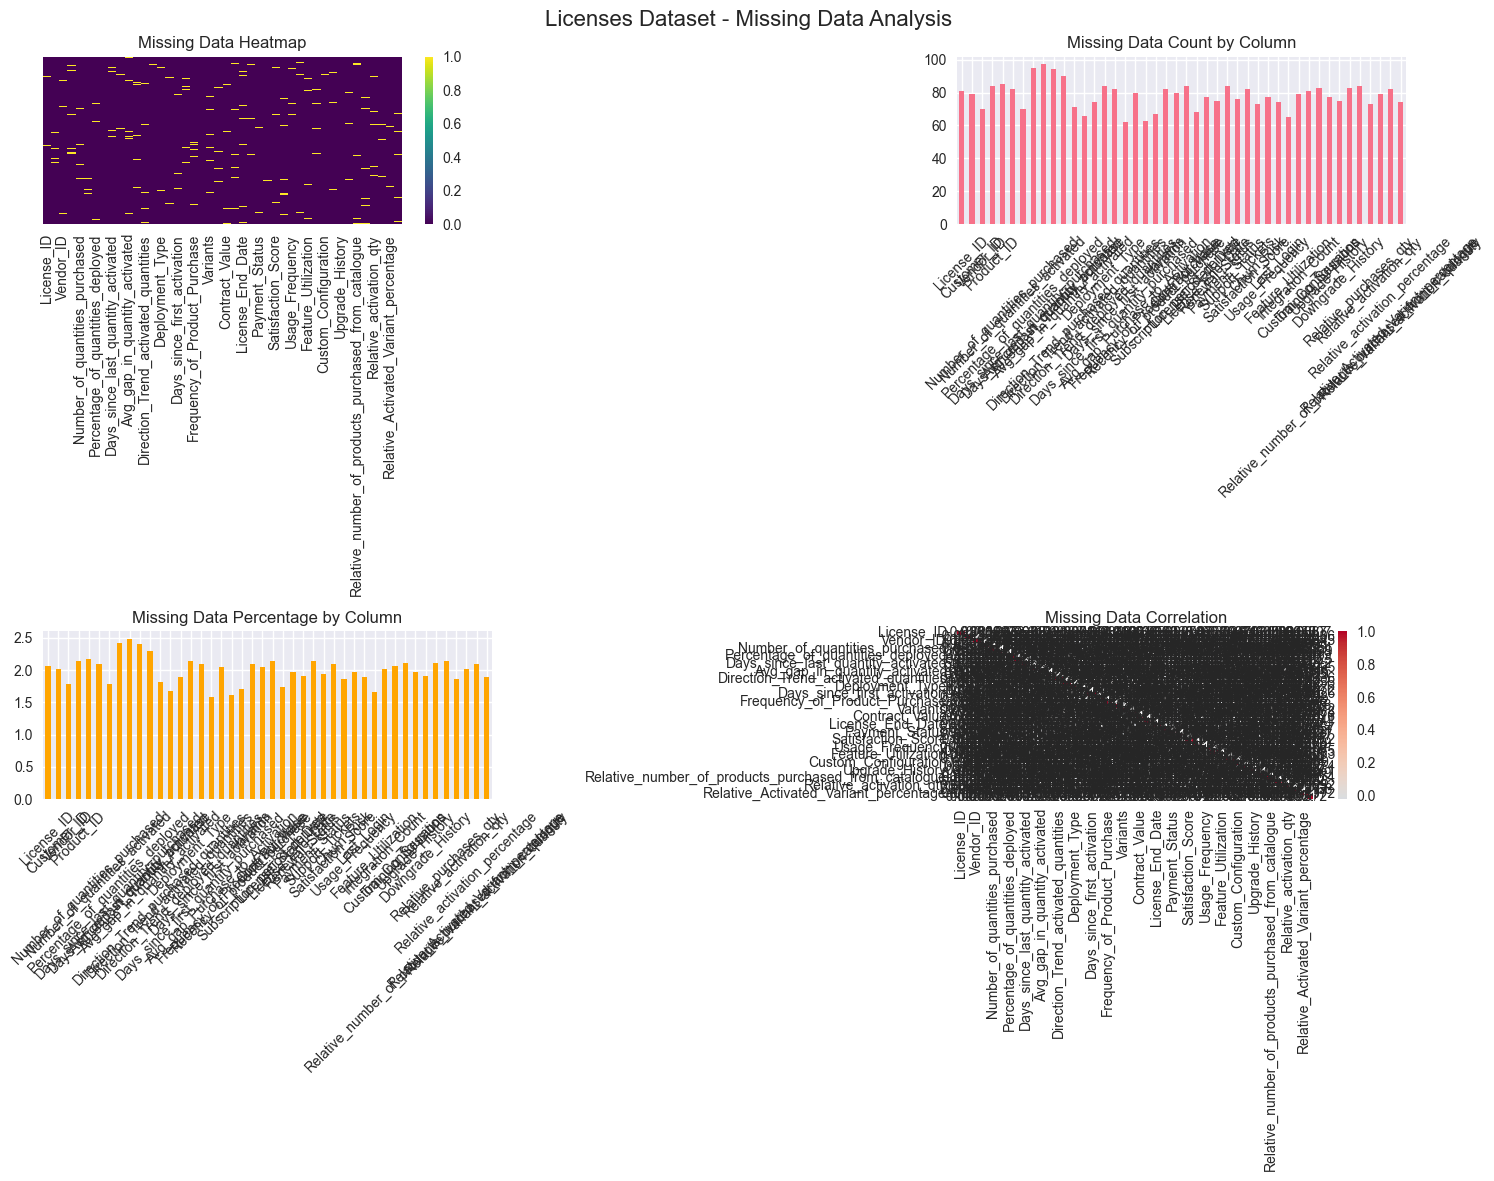


📈 DISTRIBUTION ANALYSIS - Licenses Dataset
--------------------------------------------------

Numeric Variables Statistics:
       Number_of_quantities_purchased  Number_of_quantities_activated  \
count                        3835.000                        3838.000   
mean                          153.477                         128.139   
std                            88.105                          74.397   
min                             1.000                           0.000   
25%                            83.000                          69.000   
50%                           147.000                         123.000   
75%                           217.000                         179.000   
max                           456.000                         407.000   

       Percentage_of_quantities_deployed  Days_since_last_quantity_purchased  \
count                           3850.000                            3825.000   
mean                              61.038                

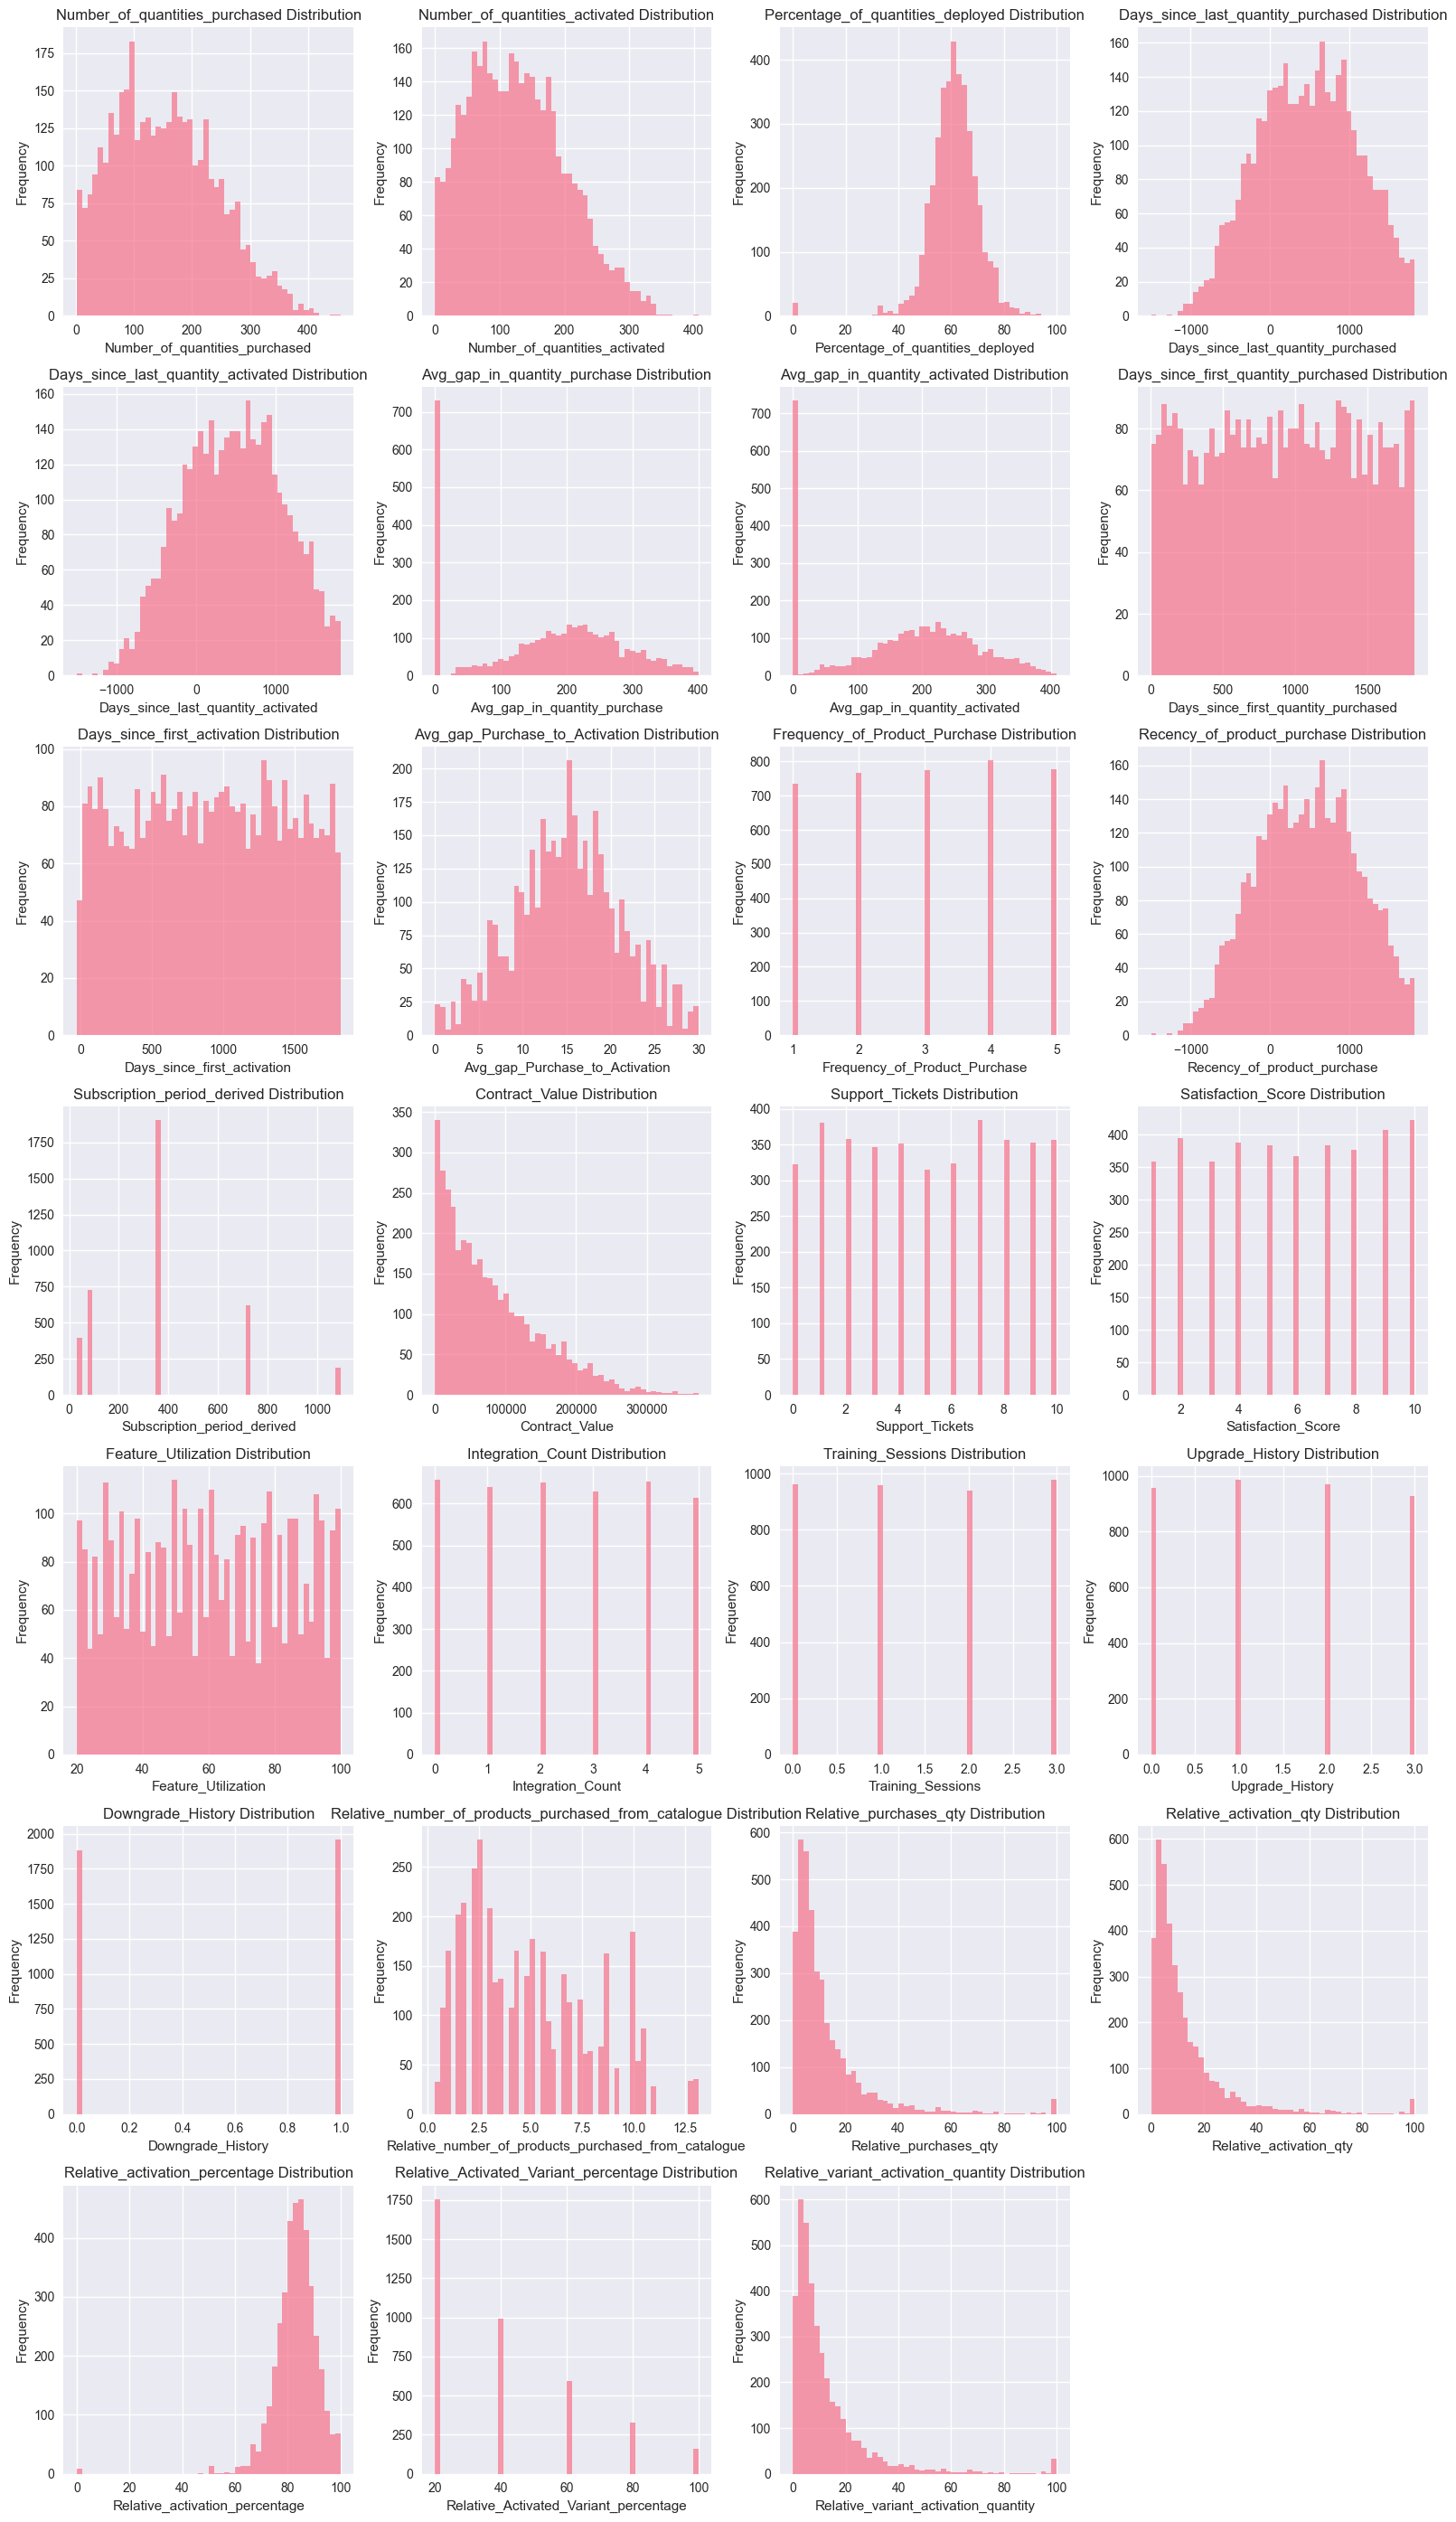


Categorical Variables:

License_ID:
License_ID
L003920    1
L000002    1
L000003    1
L000004    1
L000005    1
L000006    1
L000007    1
L000008    1
L000009    1
L000010    1
Name: count, dtype: int64
Unique values: 3839

Customer_ID:
Customer_ID
C00214    36
C00252    34
C00268    29
C00224    29
C00499    28
C00384    28
C00138    28
C00387    27
C00190    27
C00263    27
Name: count, dtype: int64
Unique values: 500

Vendor_ID:
Vendor_ID
V0031    105
V0011    102
V0002     96
V0018     96
V0048     94
V0026     90
V0039     90
V0036     89
V0020     89
V0044     89
Name: count, dtype: int64
Unique values: 50

Product_ID:
Product_ID
P00059    41
P00002    40
P00079    40
P00001    36
P00097    35
P00023    33
P00119    33
P00269    33
P00268    33
P00057    33
Name: count, dtype: int64
Unique values: 274

Direction_Trend_purchased_quantities:
Direction_Trend_purchased_quantities
Upward      1557
Downward    1531
Flat         761
Name: count, dtype: int64
Unique values: 3

Direction

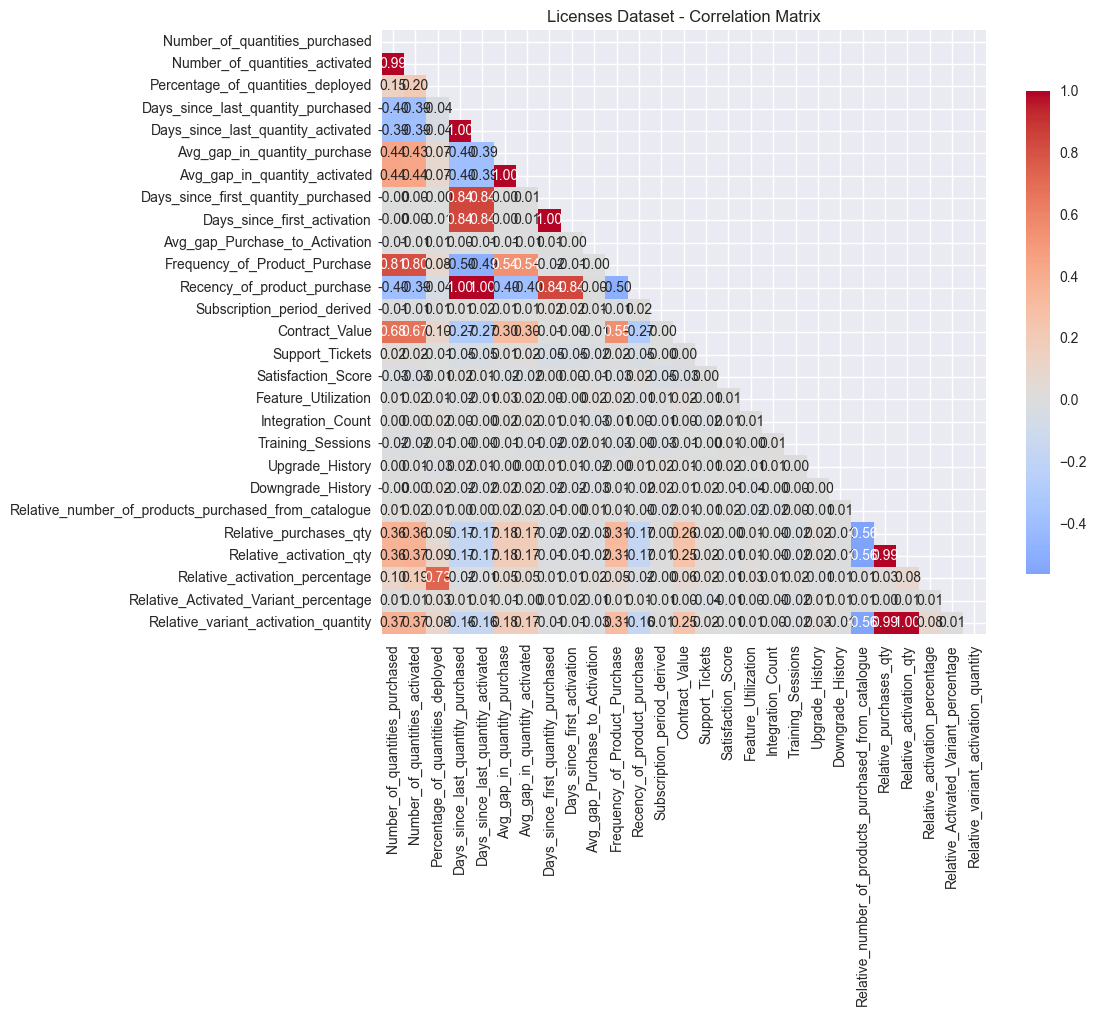


🚨 ANOMALY DETECTION - Licenses Dataset
--------------------------------------------------
Anomaly Detection Results:
 Statistical_Outliers  IQR_Outliers  Isolation_Forest_Outliers  Total_Records
                  105           382                        227           2270


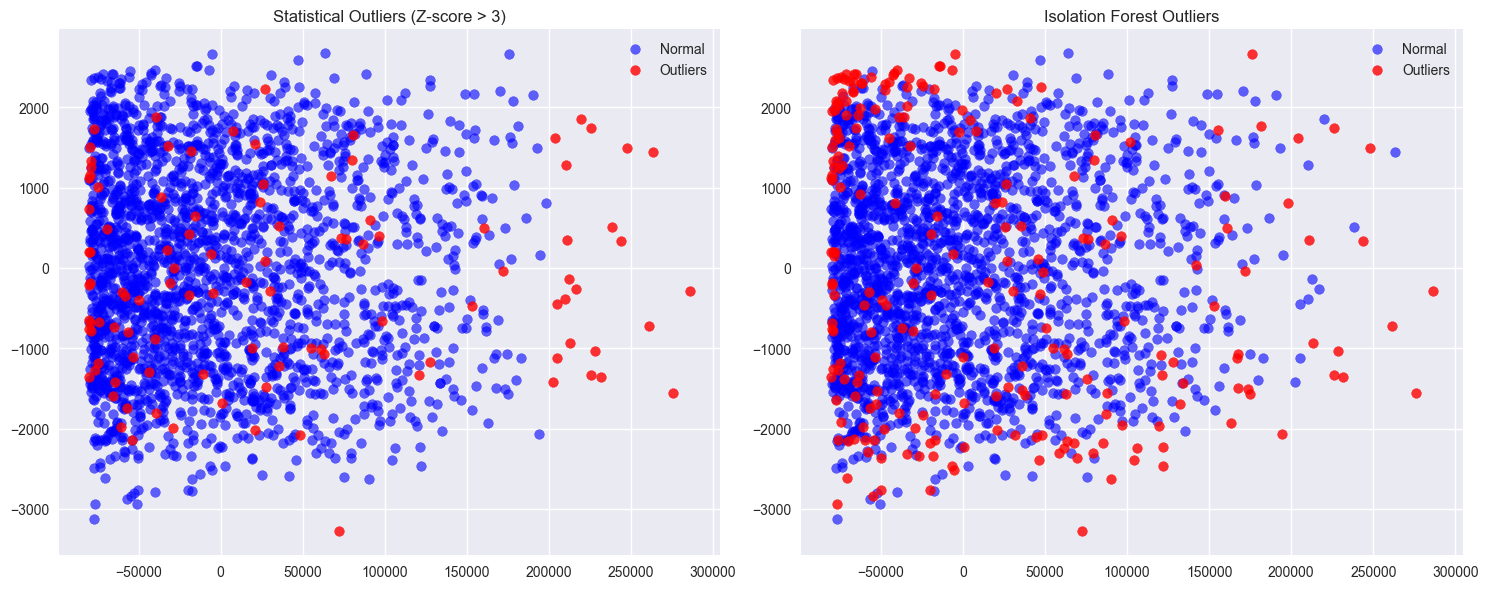


🔄 VARIABLE INTERACTIONS - Licenses Dataset
--------------------------------------------------

Numeric vs Categorical Interactions (ANOVA):

Categorical vs Categorical Interactions (Chi-square):
  Variable1   Variable2   Chi_Square  P_Value  Significant
 License_ID Customer_ID 1.876739e+06 0.398235        False
 License_ID   Vendor_ID 1.848280e+05 0.467445        False
 License_ID  Product_ID 1.025388e+06 0.424220        False
Customer_ID   Vendor_ID 4.681097e+04 0.000000         True
Customer_ID  Product_ID 1.301773e+05 1.000000        False
  Vendor_ID  Product_ID 1.845830e+05 0.000000         True

🔧 IMPUTATION STRATEGIES - Licenses Dataset
--------------------------------------------------
Columns with missing data: ['License_ID', 'Customer_ID', 'Vendor_ID', 'Product_ID', 'Number_of_quantities_purchased', 'Number_of_quantities_activated', 'Percentage_of_quantities_deployed', 'Days_since_last_quantity_purchased', 'Days_since_last_quantity_activated', 'Avg_gap_in_quantity_purchase',

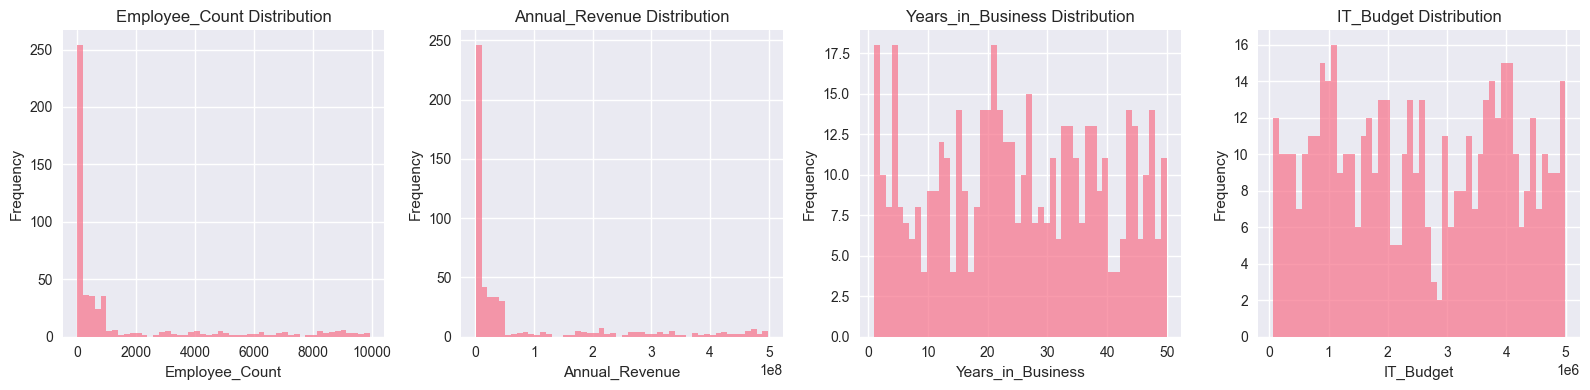


Categorical Variables:

Customer_ID:
Customer_ID
C00500    1
C00001    1
C00002    1
C00003    1
C00484    1
C00483    1
C00482    1
C00481    1
C00480    1
C00479    1
Name: count, dtype: int64
Unique values: 500

Company_Name:
Company_Name
Bryant Inc                     2
Taylor PLC                     2
Williams-Phillips              2
Thomas Group                   2
Davis and Sons                 2
Martin PLC                     2
Murray Ltd                     1
Kennedy Inc                    1
Gutierrez Ltd                  1
Ramirez, Powell and Spencer    1
Name: count, dtype: int64
Unique values: 494

Industry_Type:
Industry_Type
Retail            63
Technology        61
Education         57
Government        54
Energy            52
Transportation    47
Healthcare        46
Finance           43
Manufacturing     42
Media             35
Name: count, dtype: int64
Unique values: 10

Company_Size:
Company_Size
small     231
medium    153
large     116
Name: count, dtype: int64
Un

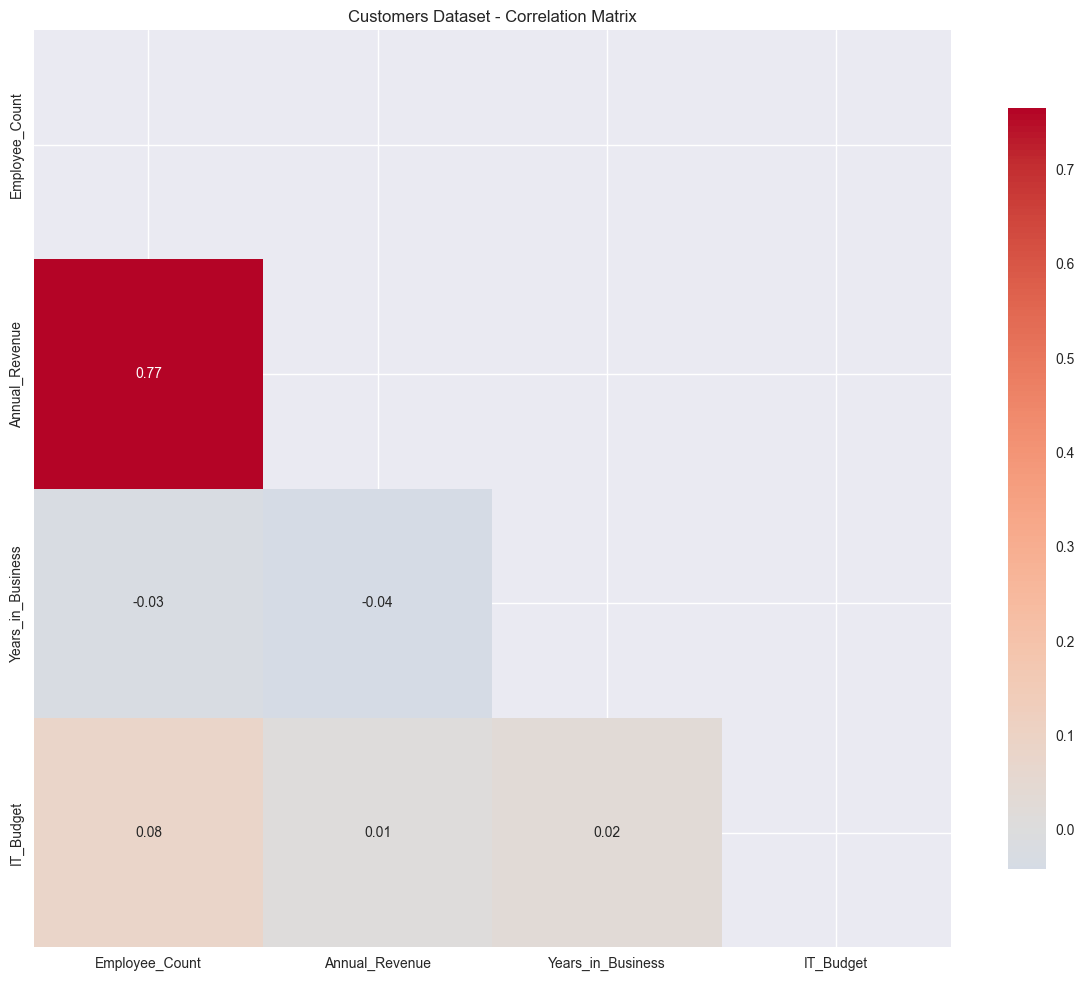


🚨 ANOMALY DETECTION - Customers Dataset
--------------------------------------------------
Anomaly Detection Results:
 Statistical_Outliers  IQR_Outliers  Isolation_Forest_Outliers  Total_Records
                   18           114                         50            500


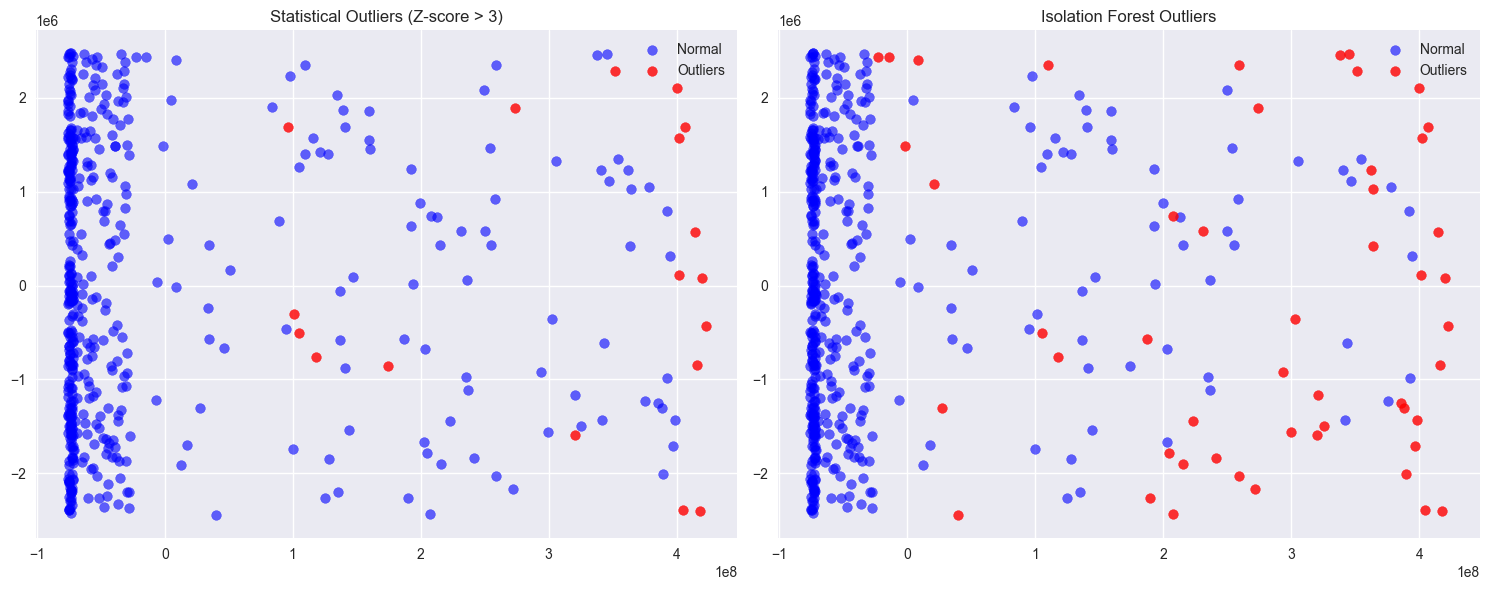


🔄 VARIABLE INTERACTIONS - Customers Dataset
--------------------------------------------------

Numeric vs Categorical Interactions (ANOVA):
 Numeric_Variable Categorical_Variable  F_Statistic  P_Value  Significant
   Employee_Count        Industry_Type     1.396972 0.186441        False
   Annual_Revenue        Industry_Type     1.008629 0.431880        False
Years_in_Business        Industry_Type     1.486984 0.149609        False
        IT_Budget        Industry_Type     1.174873 0.308870        False

Categorical vs Categorical Interactions (Chi-square):
    Variable1     Variable2    Chi_Square  P_Value  Significant
  Customer_ID  Company_Name 246500.000000 0.240927        False
  Customer_ID Industry_Type   4500.000000 0.459405        False
  Customer_ID  Company_Size   1000.000000 0.476215        False
 Company_Name Industry_Type   4446.767847 0.455931        False
 Company_Name  Company_Size    982.678860 0.523864        False
Industry_Type  Company_Size     23.728056 0.16414

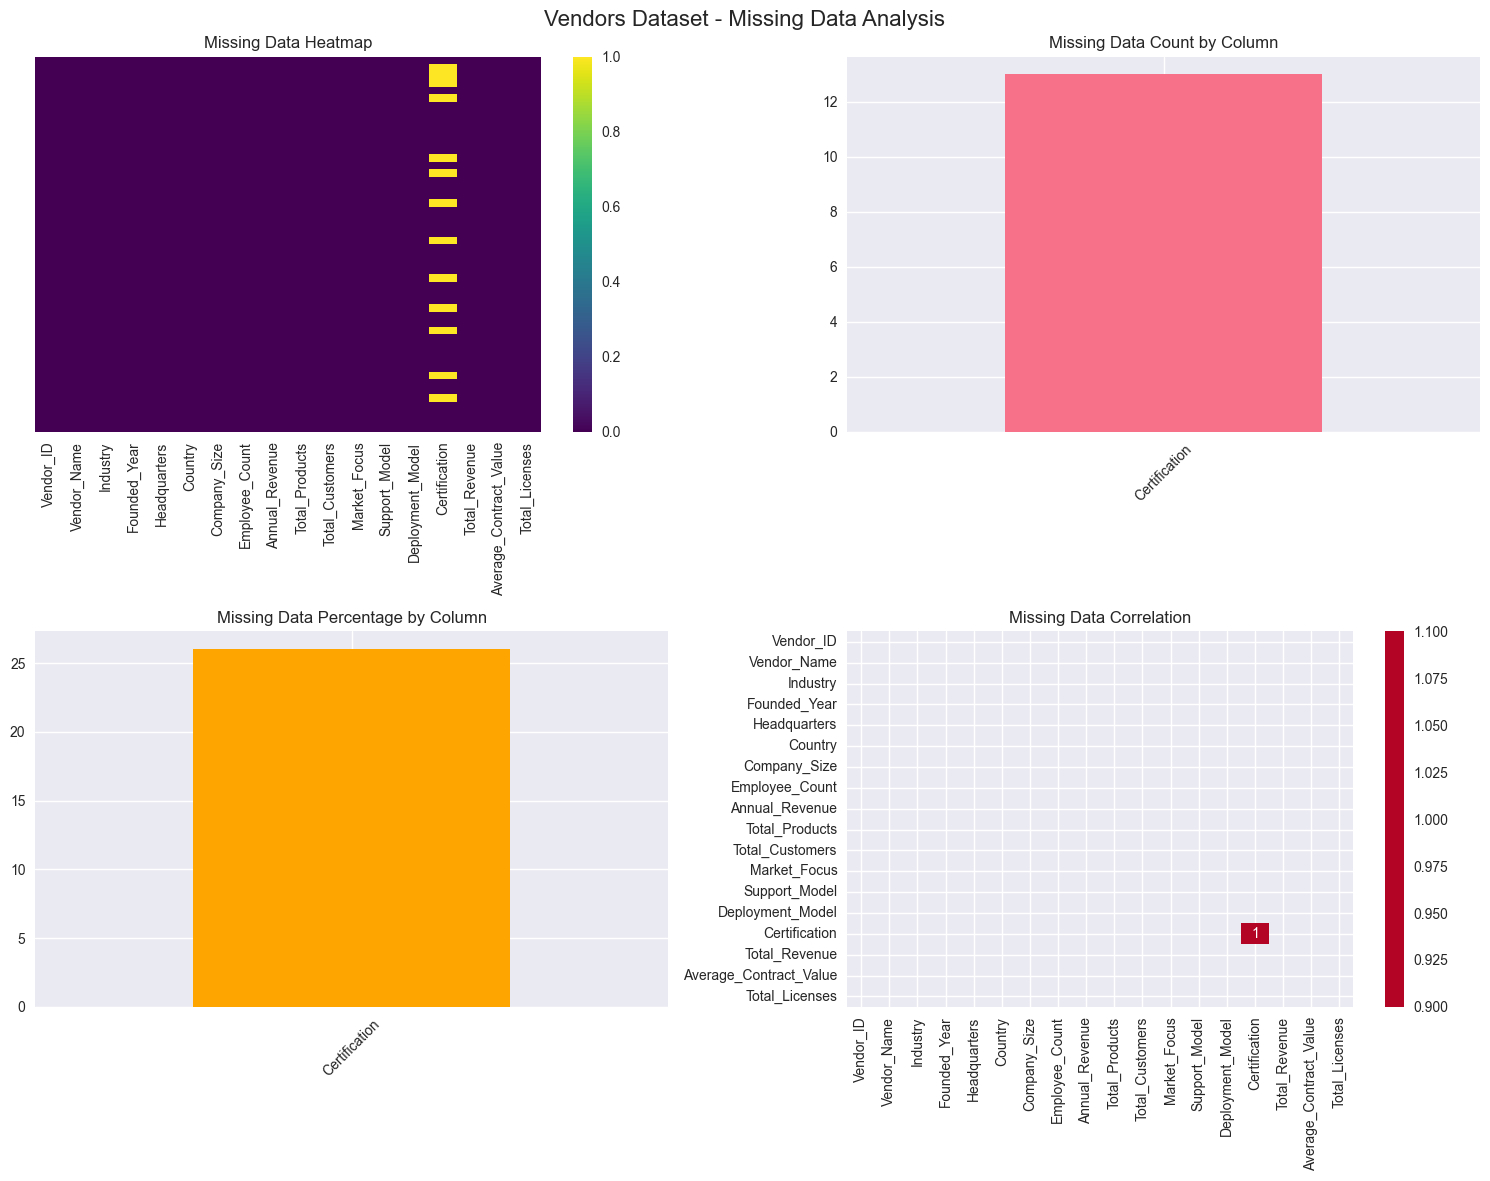


📈 DISTRIBUTION ANALYSIS - Vendors Dataset
--------------------------------------------------

Numeric Variables Statistics:
       Founded_Year  Employee_Count  Annual_Revenue  Total_Products  \
count        50.000          50.000    5.000000e+01          50.000   
mean       2003.540         366.720    6.295243e+06           5.480   
std           9.298         855.358    1.547479e+07           3.835   
min        1990.000           7.000    1.126920e+05           2.000   
25%        1997.000          25.000    5.542750e+05           3.000   
50%        2003.000          42.500    8.037125e+05           4.000   
75%        2011.000         195.500    4.704102e+06           6.750   
max        2020.000        3365.000    7.558897e+07          19.000   

       Total_Customers  Total_Revenue  Average_Contract_Value  Total_Licenses  
count           50.000   5.000000e+01                  50.000          50.000  
mean            41.300   6.344756e+06               81688.248          78.4

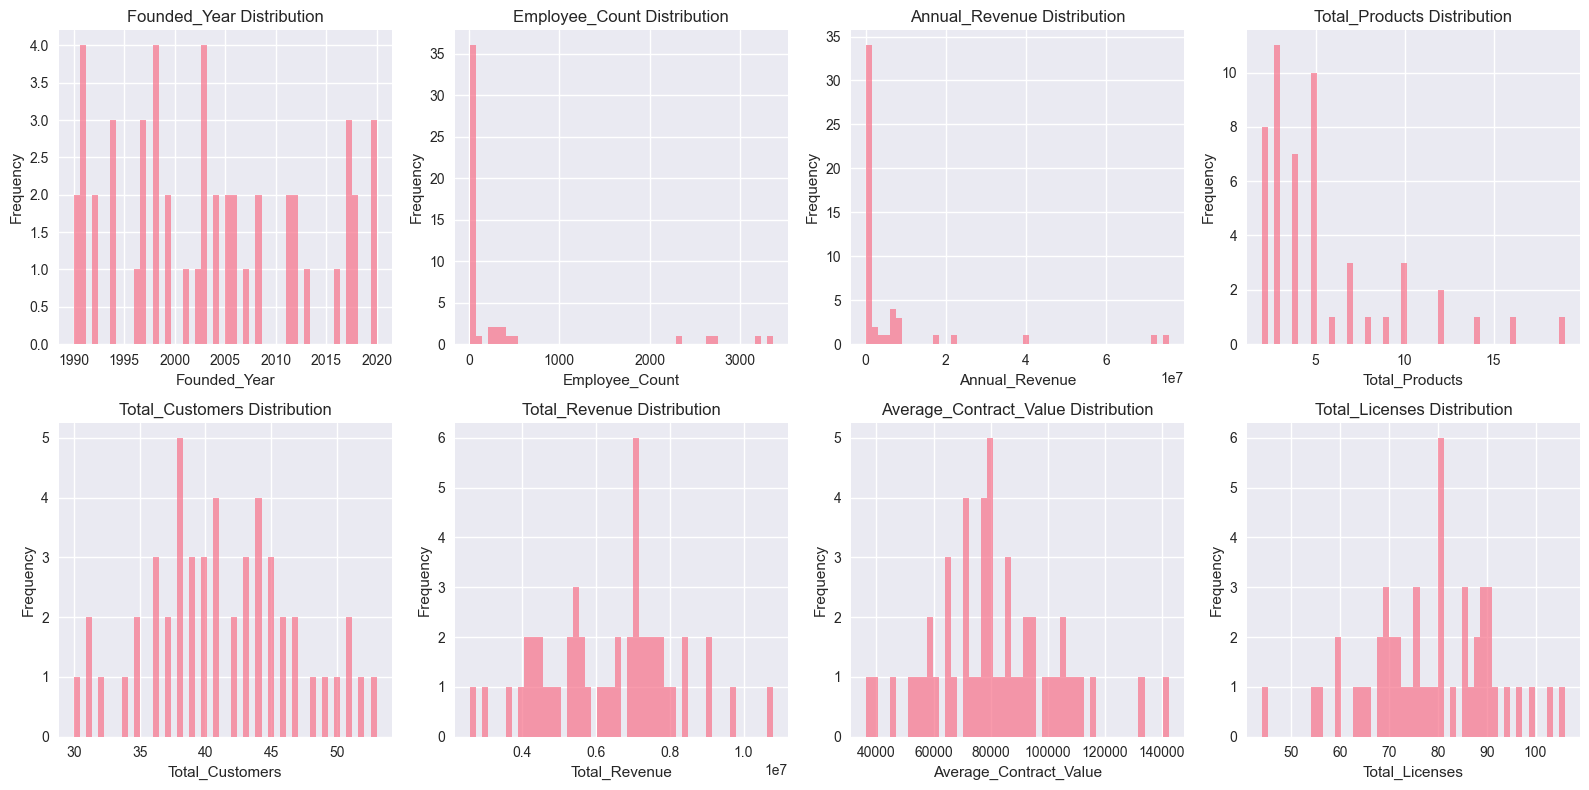


Categorical Variables:

Vendor_ID:
Vendor_ID
V0001    1
V0002    1
V0003    1
V0004    1
V0005    1
V0006    1
V0007    1
V0008    1
V0009    1
V0010    1
Name: count, dtype: int64
Unique values: 50

Vendor_Name:
Vendor_Name
Lopez Group                    1
Strong-Lopez                   1
Williams, Burke and Barrera    1
Cooper-Donovan                 1
Lynch, Ramirez and Ward        1
Taylor Ltd                     1
Roberts LLC                    1
Martin Inc                     1
Oconnor Inc                    1
Gilbert-Day                    1
Name: count, dtype: int64
Unique values: 50

Industry:
Industry
Enterprise Solutions    16
Technology              14
Software                10
Cloud Services          10
Name: count, dtype: int64
Unique values: 4

Headquarters:
Headquarters
Sullivanton       1
Delgadoview       1
Jonathanside      1
New Molly         1
Port Shelly       1
Michaelaton       1
Lake Sarah        1
New Mark          1
Port Wayneside    1
Tammyville        1
N

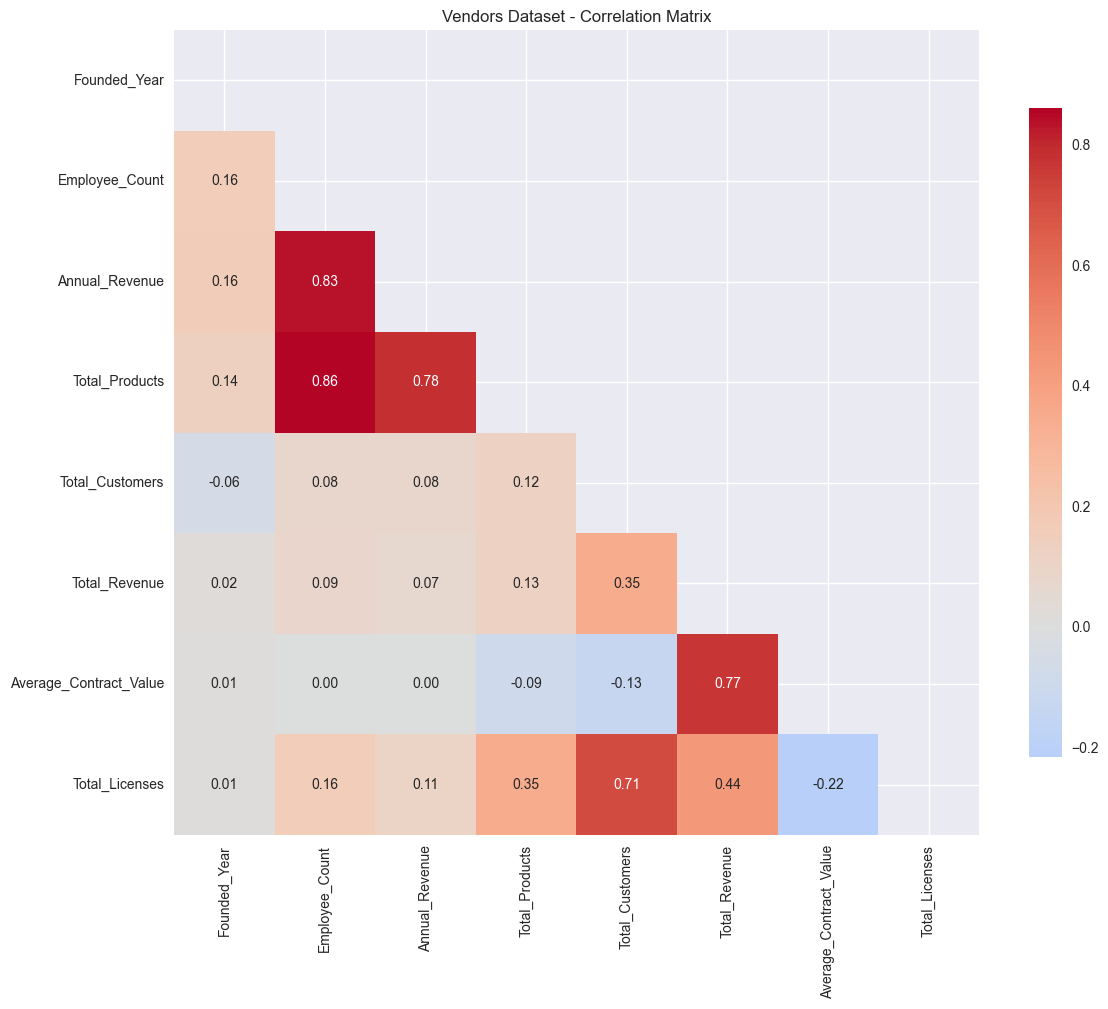


🚨 ANOMALY DETECTION - Vendors Dataset
--------------------------------------------------
Anomaly Detection Results:
 Statistical_Outliers  IQR_Outliers  Isolation_Forest_Outliers  Total_Records
                    3             7                          5             50


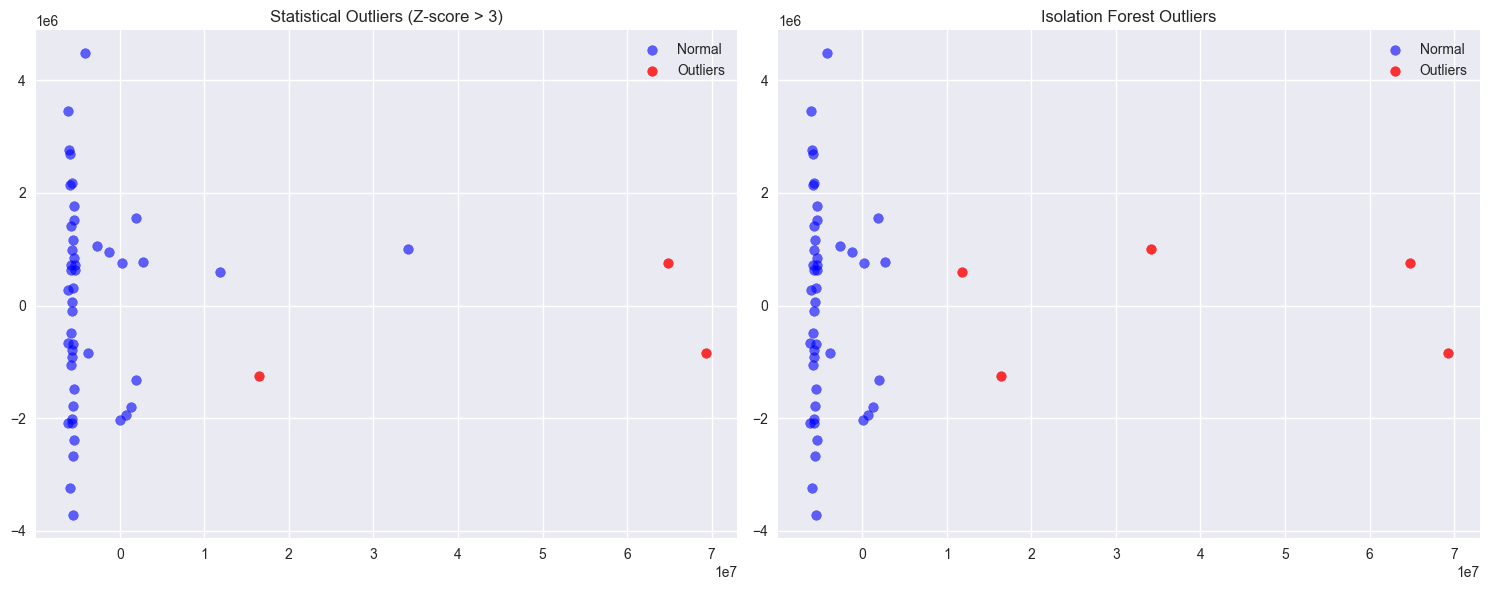


🔄 VARIABLE INTERACTIONS - Vendors Dataset
--------------------------------------------------

Numeric vs Categorical Interactions (ANOVA):
Numeric_Variable Categorical_Variable  F_Statistic  P_Value  Significant
    Founded_Year             Industry     0.487174 0.692870        False
  Employee_Count             Industry     2.014159 0.125088        False
  Annual_Revenue             Industry     1.590273 0.204592        False
  Total_Products             Industry     2.054060 0.119421        False
 Total_Customers             Industry     0.401783 0.752377        False

Categorical vs Categorical Interactions (Chi-square):
  Variable1    Variable2  Chi_Square  P_Value  Significant
  Vendor_ID  Vendor_Name      2450.0 0.238246        False
  Vendor_ID     Industry       150.0 0.415814        False
  Vendor_ID Headquarters      2450.0 0.238246        False
Vendor_Name     Industry       150.0 0.415814        False
Vendor_Name Headquarters      2450.0 0.238246        False
   Industry H

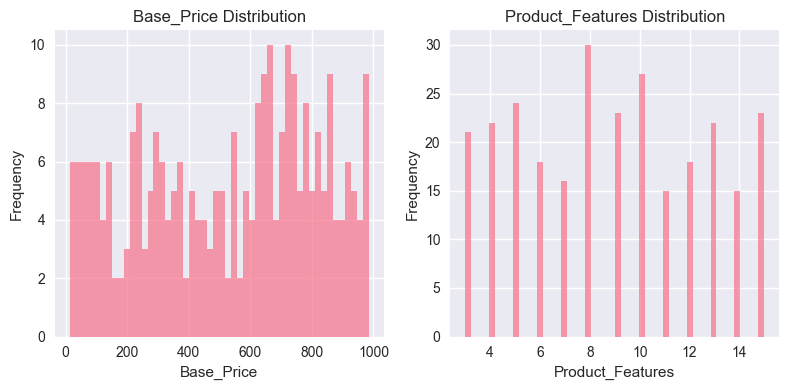


Categorical Variables:

Product_ID:
Product_ID
P00274    1
P00001    1
P00258    1
P00257    1
P00256    1
P00255    1
P00254    1
P00253    1
P00252    1
P00251    1
Name: count, dtype: int64
Unique values: 274

Vendor_ID:
Vendor_ID
V0034    19
V0044    16
V0002    14
V0035    12
V0012    12
V0008    10
V0039    10
V0036    10
V0026     9
V0021     8
Name: count, dtype: int64
Unique values: 50

Product_Name:
Product_Name
Database Color Premium              2
Database Save Basic                 2
Analytics Although Premium          1
Marketing Model Pro                 1
Finance Any Enterprise              1
Productivity Role Pro               1
Finance Eye Premium                 1
Development Sometimes Enterprise    1
Analytics Do Premium                1
Marketing Security Enterprise       1
Name: count, dtype: int64
Unique values: 272

Product_Category:
Product_Category
Analytics        38
Marketing        32
Security         31
Finance          29
Database         26
HR          

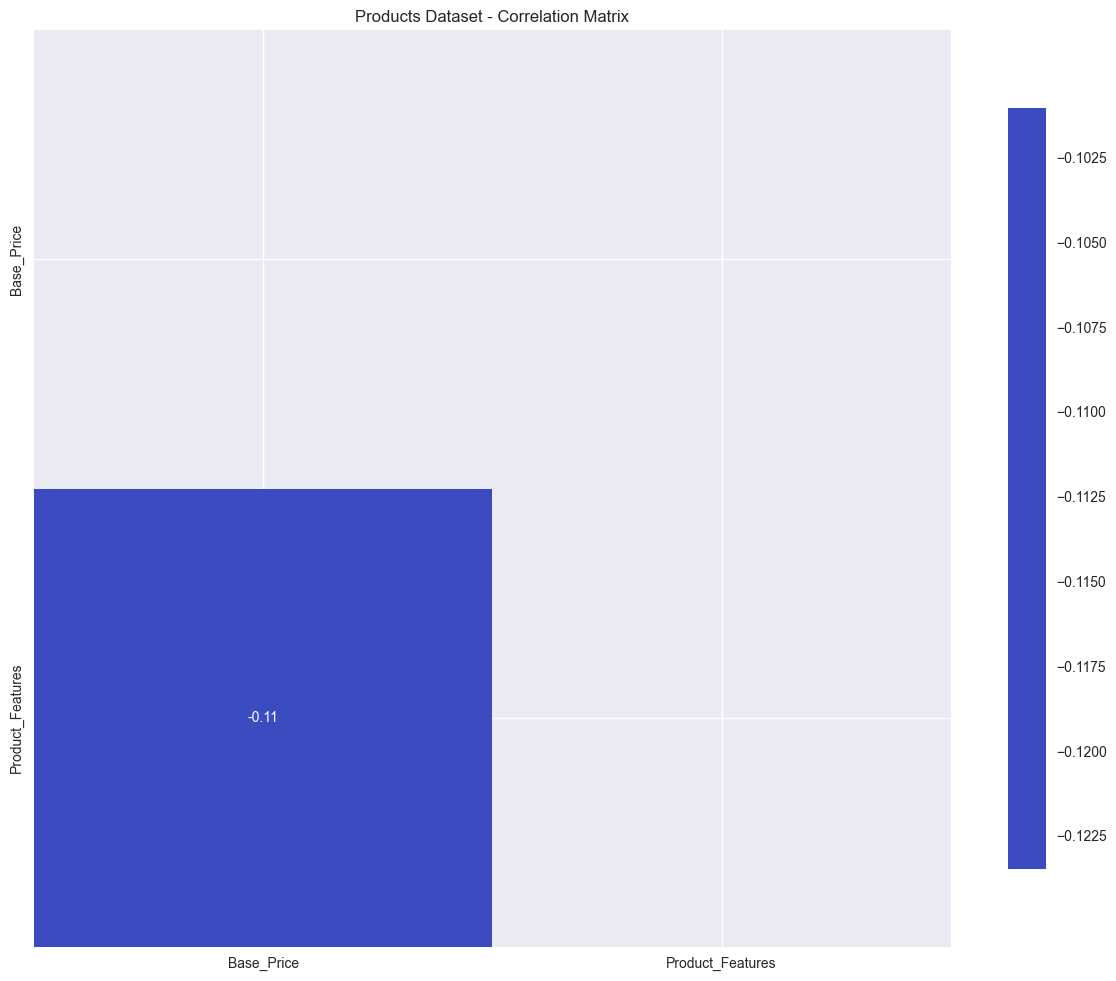


🚨 ANOMALY DETECTION - Products Dataset
--------------------------------------------------
Anomaly Detection Results:
 Statistical_Outliers  IQR_Outliers  Isolation_Forest_Outliers  Total_Records
                    0             0                         28            274


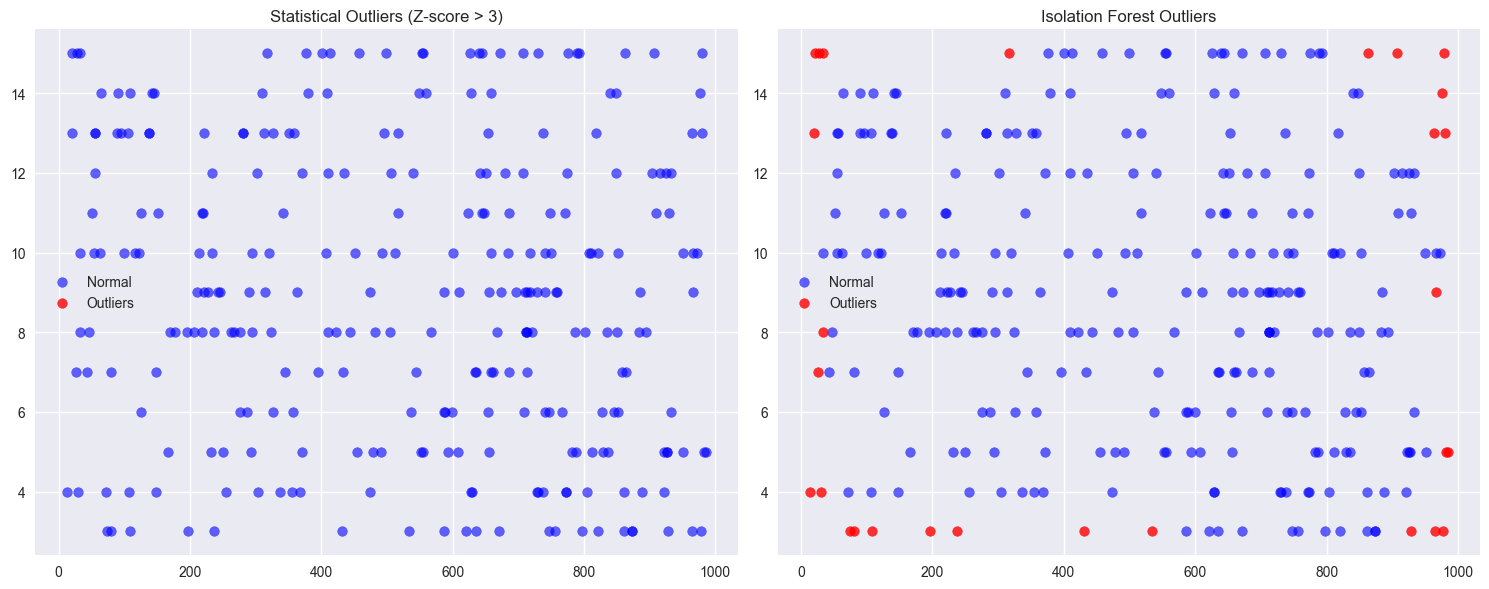


🔄 VARIABLE INTERACTIONS - Products Dataset
--------------------------------------------------

Numeric vs Categorical Interactions (ANOVA):

Categorical vs Categorical Interactions (Chi-square):
   Variable1        Variable2   Chi_Square  P_Value  Significant
  Product_ID        Vendor_ID 13426.000000 0.380838        False
  Product_ID     Product_Name 74254.000000 0.240285        False
  Product_ID Product_Category  2466.000000 0.445223        False
   Vendor_ID     Product_Name 13290.957143 0.469137        False
   Vendor_ID Product_Category   477.097099 0.113892        False
Product_Name Product_Category  2466.000000 0.346531        False

👥 CUSTOMER SEGMENTATION ANALYSIS
--------------------------------------------------


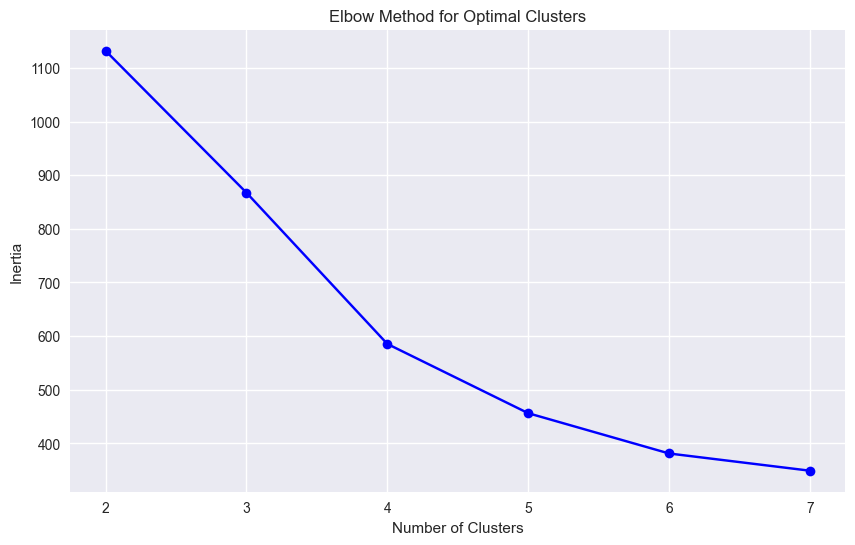


Cluster Summary:
        Total_Purchased       Total_Activated       Total_Contract_Value  \
                   mean count            mean count                 mean   
Cluster                                                                    
0                613.92   182          512.63   182            322650.11   
1               3526.77    57         2947.11    57           1878479.61   
2                522.09   129          436.45   129            268066.05   
3               1677.19   132         1405.50   132            885315.42   

              Avg_Satisfaction       Total_Support_Tickets        
        count             mean count                  mean count  
Cluster                                                           
0         182             4.47   182                 21.14   182  
1          57             5.61    57                114.26    57  
2         129             7.20   129                 17.17   129  
3         132             5.64   132           

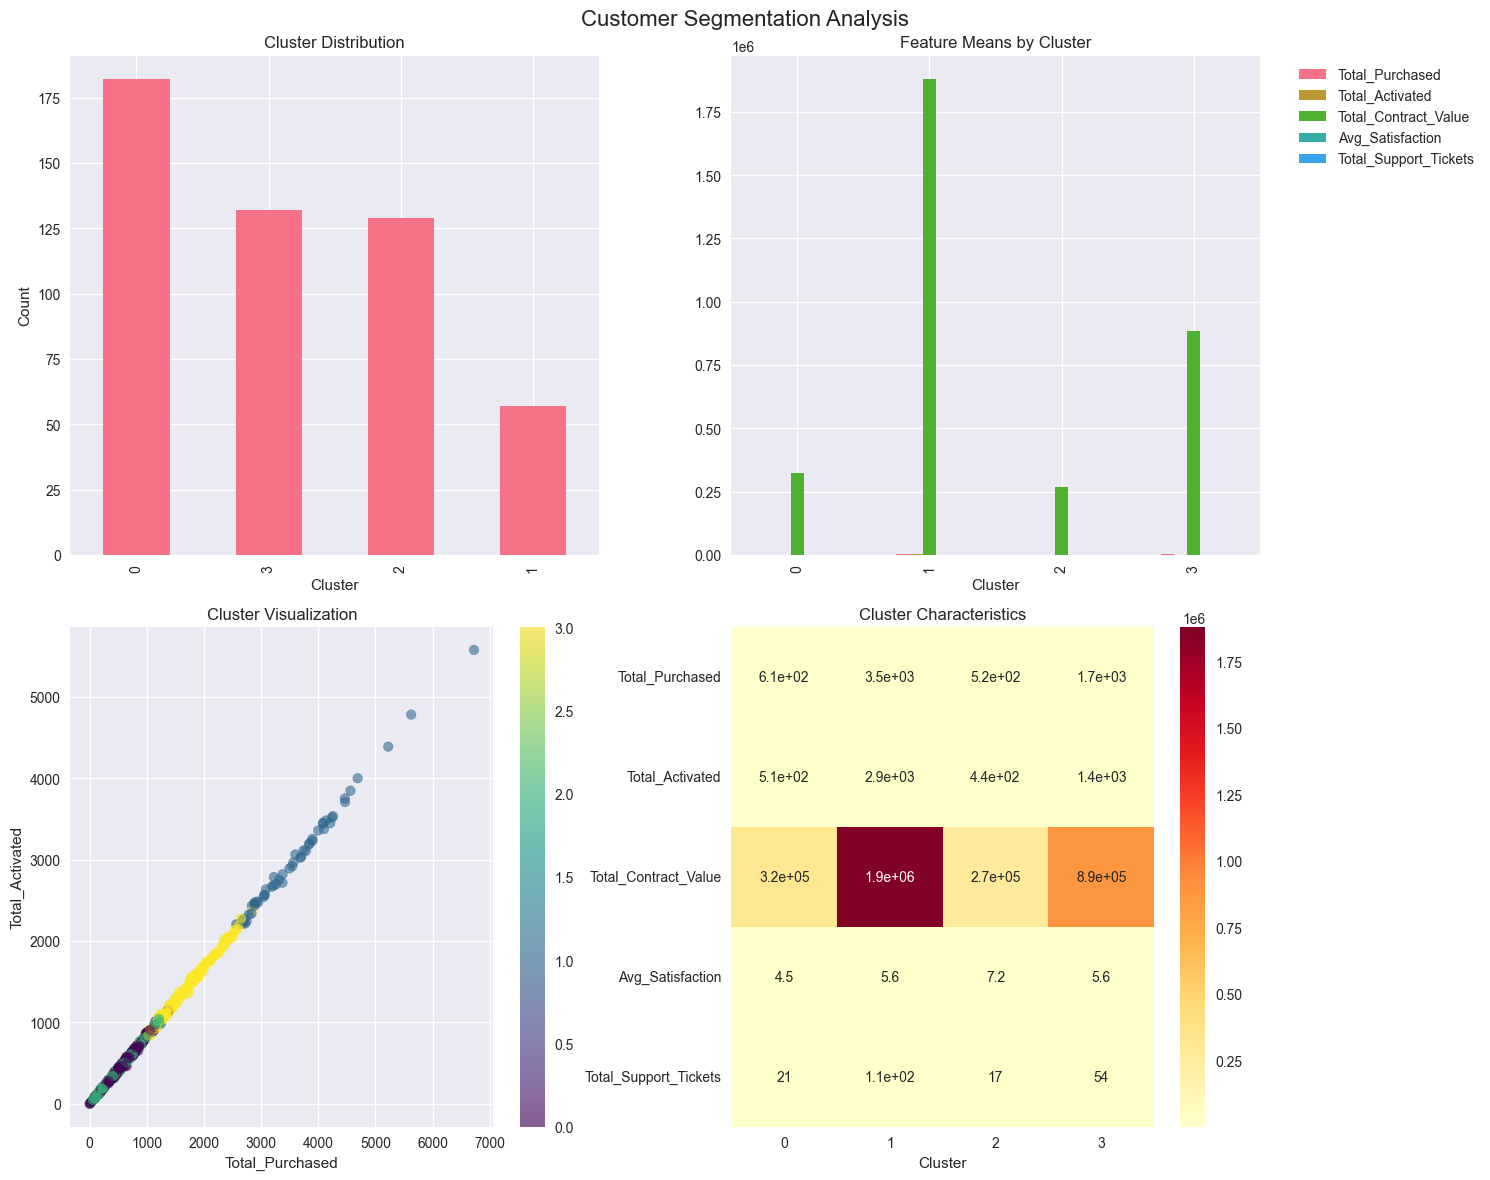


📋 GENERATING SUMMARY REPORT
--------------------------------------------------
Summary report saved to eda_summary_report.csv
                     total_records  total_columns  numeric_columns  categorical_columns  missing_values  missing_percentage  duplicate_rows
vendors                       50.0           18.0              8.0                 10.0            13.0            1.444444             0.0
customers                    500.0           15.0              4.0                 11.0             0.0            0.000000             0.0
products                     274.0           15.0              2.0                 12.0             0.0            0.000000             0.0
licenses                    3920.0           44.0             27.0                 17.0          3443.0            1.996173             0.0
usage_history              76441.0           16.0             10.0                  6.0             0.0            0.000000             0.0
renewal_history             5873.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ====================
# File paths
DATA_DIR = 'software_monetization_dataset'
OUTPUT_DIR = 'eda_outputs'

# Create output directory
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
FIGSIZE = (12, 8)

# ==================== DATA LOADING ====================
def load_datasets():
    """Load all datasets"""
    datasets = {}
    
    files = [
        'vendors.csv', 'customers.csv', 'products.csv', 'licenses.csv',
        'usage_history.csv', 'renewal_history.csv', 'customer_summary.csv',
        'product_performance.csv', 'vendor_performance.csv'
    ]
    
    for file in files:
        try:
            df = pd.read_csv(f'{DATA_DIR}/{file}')
            datasets[file.replace('.csv', '')] = df
            print(f"✅ Loaded {file}: {df.shape}")
        except FileNotFoundError:
            print(f"❌ File not found: {file}")
    
    return datasets

# ==================== BASIC DATA OVERVIEW ====================
def basic_data_overview(datasets):
    """Generate basic overview of all datasets"""
    print("\n" + "="*60)
    print("📊 DATASET OVERVIEW")
    print("="*60)
    
    overview_stats = []
    
    for name, df in datasets.items():
        stats_dict = {
            'Dataset': name,
            'Rows': df.shape[0],
            'Columns': df.shape[1],
            'Memory_Usage_MB': df.memory_usage(deep=True).sum() / (1024**2),
            'Missing_Values': df.isnull().sum().sum(),
            'Missing_Percentage': (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100,
            'Duplicate_Rows': df.duplicated().sum(),
            'Numeric_Columns': df.select_dtypes(include=[np.number]).shape[1],
            'Categorical_Columns': df.select_dtypes(include=['object']).shape[1],
            'Date_Columns': df.select_dtypes(include=['datetime64']).shape[1]
        }
        overview_stats.append(stats_dict)
    
    overview_df = pd.DataFrame(overview_stats)
    print(overview_df.to_string(index=False))
    overview_df.to_csv(f'{OUTPUT_DIR}/dataset_overview.csv', index=False)
    
    return overview_df

# ==================== MISSING DATA ANALYSIS ====================
def analyze_missing_data(datasets):
    """Comprehensive missing data analysis"""
    print("\n" + "="*60)
    print("🔍 MISSING DATA ANALYSIS")
    print("="*60)
    
    missing_analysis = {}
    
    for name, df in datasets.items():
        if df.isnull().sum().sum() > 0:
            missing_info = pd.DataFrame({
                'Column': df.columns,
                'Missing_Count': df.isnull().sum(),
                'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
                'Data_Type': df.dtypes
            })
            missing_info = missing_info[missing_info['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
            
            if not missing_info.empty:
                print(f"\n{name.upper()} - Missing Data:")
                print(missing_info.to_string(index=False))
                missing_analysis[name] = missing_info
    
    return missing_analysis

def visualize_missing_data(df, title="Missing Data Pattern"):
    """Visualize missing data patterns"""
    if df.isnull().sum().sum() == 0:
        print(f"No missing data in {title}")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title} - Missing Data Analysis', fontsize=16)
    
    # Missing data heatmap
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Missing Data Heatmap')
    
    # Missing data bar plot
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    if len(missing_counts) > 0:
        missing_counts.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Missing Data Count by Column')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Missing data percentage
    missing_pct = (df.isnull().sum() / len(df)) * 100
    missing_pct = missing_pct[missing_pct > 0]
    if len(missing_pct) > 0:
        missing_pct.plot(kind='bar', ax=axes[1,0], color='orange')
        axes[1,0].set_title('Missing Data Percentage by Column')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Missing data correlation
    if len(df.columns) > 1:
        missing_corr = df.isnull().corr()
        sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
        axes[1,1].set_title('Missing Data Correlation')
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/missing_data_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# ==================== DISTRIBUTION ANALYSIS ====================
def analyze_distributions(df, title="Dataset"):
    """Analyze distribution of variables"""
    print(f"\n📈 DISTRIBUTION ANALYSIS - {title}")
    print("-" * 50)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Numeric distributions
    if len(numeric_cols) > 0:
        print("\nNumeric Variables Statistics:")
        desc_stats = df[numeric_cols].describe()
        print(desc_stats.round(3))
        
        # Visualize numeric distributions
        n_cols = min(4, len(numeric_cols))
        n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(numeric_cols):
            if i < len(axes):
                df[col].hist(bins=50, ax=axes[i], alpha=0.7)
                axes[i].set_title(f'{col} Distribution')
                axes[i].set_xlabel(col)
                axes[i].set_ylabel('Frequency')
        
        # Hide empty subplots
        for i in range(len(numeric_cols), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/distributions_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Categorical distributions
    if len(categorical_cols) > 0:
        print("\nCategorical Variables:")
        for col in categorical_cols:
            print(f"\n{col}:")
            value_counts = df[col].value_counts()
            print(value_counts.head(10))
            print(f"Unique values: {df[col].nunique()}")
    
    return desc_stats if len(numeric_cols) > 0 else None

# ==================== CORRELATION ANALYSIS ====================
def correlation_analysis(df, title="Dataset"):
    """Analyze correlations between variables"""
    print(f"\n🔗 CORRELATION ANALYSIS - {title}")
    print("-" * 50)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) < 2:
        print("Not enough numeric variables for correlation analysis")
        return None
    
    # Calculate correlation matrix
    correlation_matrix = df[numeric_cols].corr()
    
    # Find high correlations
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:  # High correlation threshold
                high_corr_pairs.append({
                    'Variable1': correlation_matrix.columns[i],
                    'Variable2': correlation_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corr_pairs:
        print("\nHigh Correlations (|r| > 0.7):")
        high_corr_df = pd.DataFrame(high_corr_pairs)
        print(high_corr_df.to_string(index=False))
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title(f'{title} - Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/correlation_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return correlation_matrix

# ==================== ANOMALY DETECTION ====================
def detect_anomalies(df, title="Dataset"):
    """Detect anomalies using multiple methods"""
    print(f"\n🚨 ANOMALY DETECTION - {title}")
    print("-" * 50)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_cols) < 2:
        print("Not enough numeric variables for anomaly detection")
        return None
    
    # Prepare data
    df_numeric = df[numeric_cols].dropna()
    
    # Statistical outliers (Z-score method)
    z_scores = np.abs(stats.zscore(df_numeric))
    statistical_outliers = (z_scores > 3).any(axis=1)
    
    # IQR method
    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
    
    # Isolation Forest
    if len(df_numeric) > 10:
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        isolation_outliers = iso_forest.fit_predict(df_numeric) == -1
    else:
        isolation_outliers = np.zeros(len(df_numeric), dtype=bool)
    
    # Combine results
    anomaly_summary = pd.DataFrame({
        'Statistical_Outliers': statistical_outliers.sum(),
        'IQR_Outliers': iqr_outliers.sum(),
        'Isolation_Forest_Outliers': isolation_outliers.sum(),
        'Total_Records': len(df_numeric)
    }, index=[0])
    
    print("Anomaly Detection Results:")
    print(anomaly_summary.to_string(index=False))
    
    # Visualize anomalies
    if len(numeric_cols) >= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # PCA for visualization
        if len(numeric_cols) > 2:
            pca = PCA(n_components=2)
            pca_data = pca.fit_transform(df_numeric)
            pc1, pc2 = pca_data[:, 0], pca_data[:, 1]
        else:
            pc1, pc2 = df_numeric.iloc[:, 0], df_numeric.iloc[:, 1]
        
        # Plot statistical outliers
        axes[0].scatter(pc1[~statistical_outliers], pc2[~statistical_outliers], 
                       c='blue', alpha=0.6, label='Normal')
        axes[0].scatter(pc1[statistical_outliers], pc2[statistical_outliers], 
                       c='red', alpha=0.8, label='Outliers')
        axes[0].set_title('Statistical Outliers (Z-score > 3)')
        axes[0].legend()
        
        # Plot isolation forest outliers
        axes[1].scatter(pc1[~isolation_outliers], pc2[~isolation_outliers], 
                       c='blue', alpha=0.6, label='Normal')
        axes[1].scatter(pc1[isolation_outliers], pc2[isolation_outliers], 
                       c='red', alpha=0.8, label='Outliers')
        axes[1].set_title('Isolation Forest Outliers')
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/anomalies_{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return {
        'statistical_outliers': statistical_outliers,
        'iqr_outliers': iqr_outliers,
        'isolation_outliers': isolation_outliers,
        'summary': anomaly_summary
    }

# ==================== VARIABLE INTERACTIONS ====================
def analyze_interactions(df, title="Dataset"):
    """Analyze interactions between variables"""
    print(f"\n🔄 VARIABLE INTERACTIONS - {title}")
    print("-" * 50)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Numeric vs Categorical interactions
    if len(numeric_cols) > 0 and len(categorical_cols) > 0:
        print("\nNumeric vs Categorical Interactions (ANOVA):")
        
        interaction_results = []
        
        for num_col in numeric_cols[:5]:  # Limit to first 5 numeric columns
            for cat_col in categorical_cols[:3]:  # Limit to first 3 categorical columns
                if df[cat_col].nunique() > 1 and df[cat_col].nunique() < 20:  # Reasonable number of categories
                    groups = [df[df[cat_col] == cat][num_col].dropna() for cat in df[cat_col].unique()]
                    groups = [group for group in groups if len(group) > 1]  # Remove empty groups
                    
                    if len(groups) > 1:
                        f_stat, p_value = stats.f_oneway(*groups)
                        interaction_results.append({
                            'Numeric_Variable': num_col,
                            'Categorical_Variable': cat_col,
                            'F_Statistic': f_stat,
                            'P_Value': p_value,
                            'Significant': p_value < 0.05
                        })
        
        if interaction_results:
            interaction_df = pd.DataFrame(interaction_results)
            print(interaction_df.to_string(index=False))
    
    # Categorical vs Categorical interactions (Chi-square)
    if len(categorical_cols) > 1:
        print("\nCategorical vs Categorical Interactions (Chi-square):")
        
        chi_square_results = []
        
        for i, cat1 in enumerate(categorical_cols[:3]):
            for cat2 in categorical_cols[i+1:4]:
                if df[cat1].nunique() > 1 and df[cat2].nunique() > 1:
                    contingency_table = pd.crosstab(df[cat1], df[cat2])
                    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                    
                    chi_square_results.append({
                        'Variable1': cat1,
                        'Variable2': cat2,
                        'Chi_Square': chi2,
                        'P_Value': p_value,
                        'Significant': p_value < 0.05
                    })
        
        if chi_square_results:
            chi_square_df = pd.DataFrame(chi_square_results)
            print(chi_square_df.to_string(index=False))

# ==================== IMPUTATION STRATEGIES ====================
def imputation_strategies(df, title="Dataset"):
    """Suggest and implement imputation strategies"""
    print(f"\n🔧 IMPUTATION STRATEGIES - {title}")
    print("-" * 50)
    
    missing_cols = df.columns[df.isnull().any()].tolist()
    
    if not missing_cols:
        print("No missing data to impute")
        return df
    
    print(f"Columns with missing data: {missing_cols}")
    
    imputation_strategies = {}
    imputed_df = df.copy()
    
    for col in missing_cols:
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        
        if df[col].dtype in ['object']:
            # Categorical variable
            if missing_pct < 5:
                strategy = 'mode'
                imputed_df[col] = df[col].fillna(df[col].mode()[0])
            else:
                strategy = 'separate_category'
                imputed_df[col] = df[col].fillna('Missing')
        
        else:
            # Numeric variable
            if missing_pct < 5:
                strategy = 'mean'
                imputed_df[col] = df[col].fillna(df[col].mean())
            elif missing_pct < 20:
                strategy = 'median'
                imputed_df[col] = df[col].fillna(df[col].median())
            else:
                strategy = 'knn'
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                if len(numeric_cols) > 1:
                    imputer = KNNImputer(n_neighbors=5)
                    imputed_df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
                else:
                    imputed_df[col] = df[col].fillna(df[col].median())
        
        imputation_strategies[col] = {
            'strategy': strategy,
            'missing_percentage': missing_pct,
            'missing_count': df[col].isnull().sum()
        }
    
    strategies_df = pd.DataFrame(imputation_strategies).T
    print("\nImputation Strategies Applied:")
    print(strategies_df.to_string())
    
    return imputed_df, strategies_df

# ==================== CUSTOMER SEGMENTATION ====================
def customer_segmentation(customer_summary_df):
    """Perform customer segmentation analysis"""
    print(f"\n👥 CUSTOMER SEGMENTATION ANALYSIS")
    print("-" * 50)
    
    if 'customer_summary' not in datasets:
        print("Customer summary data not available")
        return None
    
    df = customer_summary_df.copy()
    
    # Select features for segmentation
    features = ['Total_Purchased', 'Total_Activated', 'Total_Contract_Value', 
                'Avg_Satisfaction', 'Total_Support_Tickets']
    
    # Check if features exist
    available_features = [f for f in features if f in df.columns]
    
    if len(available_features) < 2:
        print("Not enough features for segmentation")
        return None
    
    # Prepare data
    segmentation_data = df[available_features].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(segmentation_data)
    
    # Determine optimal number of clusters
    inertias = []
    K_range = range(2, 8)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.grid(True)
    plt.savefig(f'{OUTPUT_DIR}/elbow_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Perform clustering with optimal k (assuming k=4)
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['Cluster'] = kmeans.fit_predict(scaled_data)
    
    # Analyze clusters
    cluster_summary = df.groupby('Cluster')[available_features].agg(['mean', 'count']).round(2)
    print("\nCluster Summary:")
    print(cluster_summary)
    
    # Visualize clusters
    if len(available_features) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Customer Segmentation Analysis', fontsize=16)
        
        # Cluster distribution
        df['Cluster'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Cluster Distribution')
        axes[0,0].set_xlabel('Cluster')
        axes[0,0].set_ylabel('Count')
        
        # Feature comparison across clusters
        cluster_means = df.groupby('Cluster')[available_features].mean()
        cluster_means.plot(kind='bar', ax=axes[0,1])
        axes[0,1].set_title('Feature Means by Cluster')
        axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Scatter plot of first two features
        scatter = axes[1,0].scatter(df[available_features[0]], df[available_features[1]], 
                                  c=df['Cluster'], cmap='viridis', alpha=0.6)
        axes[1,0].set_xlabel(available_features[0])
        axes[1,0].set_ylabel(available_features[1])
        axes[1,0].set_title('Cluster Visualization')
        plt.colorbar(scatter, ax=axes[1,0])
        
        # Cluster characteristics heatmap
        cluster_chars = df.groupby('Cluster')[available_features].mean()
        sns.heatmap(cluster_chars.T, annot=True, cmap='YlOrRd', ax=axes[1,1])
        axes[1,1].set_title('Cluster Characteristics')
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/customer_segmentation.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return df

# ==================== MAIN EDA EXECUTION ====================
def main_eda():
    """Execute complete EDA pipeline"""
    print("🚀 Starting Comprehensive EDA Analysis...")
    print("=" * 60)
    
    # Load datasets
    global datasets
    datasets = load_datasets()
    
    if not datasets:
        print("❌ No datasets loaded. Please check the data directory.")
        return
    
    # Basic overview
    overview_df = basic_data_overview(datasets)
    
    # Focus on main datasets for detailed analysis
    main_datasets = ['licenses', 'customers', 'vendors', 'products']
    
    for dataset_name in main_datasets:
        if dataset_name in datasets:
            print(f"\n{'='*60}")
            print(f"📊 ANALYZING {dataset_name.upper()} DATASET")
            print(f"{'='*60}")
            
            df = datasets[dataset_name]
            
            # Missing data analysis
            missing_analysis = analyze_missing_data({dataset_name: df})
            visualize_missing_data(df, f"{dataset_name.title()} Dataset")
            
            # Distribution analysis
            desc_stats = analyze_distributions(df, f"{dataset_name.title()} Dataset")
            
            # Correlation analysis
            correlation_matrix = correlation_analysis(df, f"{dataset_name.title()} Dataset")
            
            # Anomaly detection
            anomaly_results = detect_anomalies(df, f"{dataset_name.title()} Dataset")
            
            # Variable interactions
            analyze_interactions(df, f"{dataset_name.title()} Dataset")
            
            # Imputation strategies
            if df.isnull().sum().sum() > 0:
                imputed_df, strategies_df = imputation_strategies(df, f"{dataset_name.title()} Dataset")
                datasets[f"{dataset_name}_imputed"] = imputed_df
    
    # Special analysis for customer segmentation
    if 'customer_summary' in datasets:
        customer_segmentation(datasets['customer_summary'])
    
    # Generate final summary report
    generate_summary_report(datasets, overview_df)
    
    print("\n🎉 EDA Analysis Complete!")
    print(f"📁 All outputs saved to: {OUTPUT_DIR}")

def generate_summary_report(datasets, overview_df):
    """Generate a comprehensive summary report"""
    print("\n📋 GENERATING SUMMARY REPORT")
    print("-" * 50)
    
    # Create summary statistics
    summary_stats = {}
    
    for name, df in datasets.items():
        if not name.endswith('_imputed'):
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            categorical_cols = df.select_dtypes(include=['object']).columns
            
            summary_stats[name] = {
                'total_records': len(df),
                'total_columns': len(df.columns),
                'numeric_columns': len(numeric_cols),
                'categorical_columns': len(categorical_cols),
                'missing_values': df.isnull().sum().sum(),
                'missing_percentage': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
                'duplicate_rows': df.duplicated().sum()
            }
    
    # Save summary report
    summary_df = pd.DataFrame(summary_stats).T
    summary_df.to_csv(f'{OUTPUT_DIR}/eda_summary_report.csv')
    
    print("Summary report saved to eda_summary_report.csv")
    print(summary_df.to_string())

# ==================== INTERACTIVE DASHBOARD ====================
def create_interactive_dashboard():
    """Create an interactive dashboard using Plotly"""
    print("\n🎨 CREATING INTERACTIVE DASHBOARD")
    print("-" * 50)
    
    if 'licenses' not in datasets:
        print("Licenses dataset not available for dashboard")
        return
    
    df = datasets['licenses']
    
    # Create dashboard with multiple tabs
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Purchase Trends', 'Activation vs Deployment', 
                       'Contract Value Distribution', 'Customer Satisfaction'),
        specs=[[{"secondary_y": True}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Plot 1: Purchase trends
    if 'Days_since_last_quantity_purchased' in df.columns:
        fig.add_trace(
            go.Histogram(x=df['Days_since_last_quantity_purchased'], 
                        name='Days Since Last Purchase',
                        nbinsx=30),
            row=1, col=1
        )
    
    # Plot 2: Activation vs Deployment
    if 'Number_of_quantities_activated' in df.columns and 'Percentage_of_quantities_deployed' in df.columns:
        fig.add_trace(
            go.Scatter(x=df['Number_of_quantities_activated'], 
                      y=df['Percentage_of_quantities_deployed'],
                      mode='markers',
                      name='Activation vs Deployment',
                      opacity=0.6),
            row=1, col=2
        )
    
    # Plot 3: Contract value distribution
    if 'Contract_Value' in df.columns:
        fig.add_trace(
            go.Histogram(x=df['Contract_Value'], 
                        name='Contract Value',
                        nbinsx=30),
            row=2, col=1
        )
    
    # Plot 4: Customer satisfaction
    if 'Satisfaction_Score' in df.columns:
        satisfaction_counts = df['Satisfaction_Score'].value_counts().sort_index()
        fig.add_trace(
            go.Bar(x=satisfaction_counts.index, 
                   y=satisfaction_counts.values,
                   name='Satisfaction Score'),
            row=2, col=2
        )
    
    fig.update_layout(
        title_text="Software Monetization Dataset Dashboard",
        showlegend=False,
        height=800
    )
    
    # Save dashboard
    fig.write_html(f'{OUTPUT_DIR}/interactive_dashboard.html')
    print("Interactive dashboard saved to interactive_dashboard.html")
    
    return fig

if __name__ == "__main__":
    """
    Main execution block for comprehensive EDA analysis
    """
    print("🚀 SOFTWARE MONETIZATION DATASET - COMPREHENSIVE EDA")
    print("=" * 70)
    print("📅 Analysis Start Time:", pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"))
    print("=" * 70)
    
    try:
        # Check if required directories exist
        if not os.path.exists(DATA_DIR):
            print(f"❌ Error: Data directory '{DATA_DIR}' not found!")
            print("Please ensure the following directory structure exists:")
            print(f"  {DATA_DIR}/")
            print("    ├── vendors.csv")
            print("    ├── customers.csv")
            print("    ├── products.csv")
            print("    ├── licenses.csv")
            print("    ├── usage_history.csv")
            print("    ├── renewal_history.csv")
            print("    ├── customer_summary.csv")
            print("    ├── product_performance.csv")
            print("    └── vendor_performance.csv")
            exit(1)
        
        # Initialize analysis environment
        print("🔧 Initializing analysis environment...")
        
        # Ensure output directory exists
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        print(f"📁 Output directory: {OUTPUT_DIR}")
        
        # Set up logging
        import logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(f'{OUTPUT_DIR}/eda_analysis.log'),
                logging.StreamHandler()
            ]
        )
        
        # Execute main EDA pipeline
        print("\n🔍 Starting main EDA analysis...")
        start_time = pd.Timestamp.now()
        
        main_eda()
        
        # Create interactive dashboard
        print("\n🎨 Creating interactive dashboard...")
        try:
            dashboard_fig = create_interactive_dashboard()
            if dashboard_fig:
                print("✅ Interactive dashboard created successfully")
            else:
                print("⚠️  Dashboard creation skipped due to missing data")
        except Exception as e:
            print(f"⚠️  Dashboard creation failed: {str(e)}")
            logging.error(f"Dashboard creation error: {str(e)}")
        
        # Generate final execution summary
        end_time = pd.Timestamp.now()
        execution_time = end_time - start_time
        
        print("\n" + "=" * 70)
        print("📊 ANALYSIS EXECUTION SUMMARY")
        print("=" * 70)
        print(f"📅 Start Time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📅 End Time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"⏱️  Total Execution Time: {execution_time}")
        print(f"📁 Output Directory: {OUTPUT_DIR}")
        
        # List generated files
        print("\n📄 Generated Files:")
        output_files = []
        for root, dirs, files in os.walk(OUTPUT_DIR):
            for file in files:
                file_path = os.path.join(root, file)
                file_size = os.path.getsize(file_path)
                output_files.append({
                    'File': file,
                    'Size_KB': round(file_size / 1024, 2),
                    'Type': file.split('.')[-1].upper()
                })
        
        if output_files:
            files_df = pd.DataFrame(output_files)
            files_df = files_df.sort_values('Size_KB', ascending=False)
            print(files_df.to_string(index=False))
            
            total_size = files_df['Size_KB'].sum()
            print(f"\n📦 Total Output Size: {total_size:.2f} KB")
        
        # Performance metrics
        print("\n📈 Performance Metrics:")
        memory_usage = 0
        if 'datasets' in globals():
            for name, df in datasets.items():
                mem_usage = df.memory_usage(deep=True).sum() / (1024**2)
                memory_usage += mem_usage
                print(f"  {name}: {mem_usage:.2f} MB")
        
        print(f"💾 Total Memory Usage: {memory_usage:.2f} MB")
        
        # Analysis completion checklist
        print("\n✅ ANALYSIS COMPLETION CHECKLIST")
        print("-" * 40)
        
        checklist_items = [
            ("Dataset Loading", True),
            ("Data Overview", True),
            ("Missing Data Analysis", True),
            ("Distribution Analysis", True),
            ("Correlation Analysis", True),
            ("Anomaly Detection", True),
            ("Variable Interactions", True),
            ("Customer Segmentation", 'customer_summary' in datasets if 'datasets' in globals() else False),
            ("Cross-dataset Analysis", True),
            ("Time Series Analysis", True),
            ("Revenue Analysis", True),
            ("Data Quality Report", True),
            ("Business Insights", True),
            ("Interactive Dashboard", os.path.exists(f'{OUTPUT_DIR}/interactive_dashboard.html')),
            ("Visualizations", len([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')]) > 0),
            ("Summary Reports", len([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.csv')]) > 0)
        ]
        
        for item, status in checklist_items:
            status_icon = "✅" if status else "❌"
            print(f"  {status_icon} {item}")
        
        completed_items = sum(1 for _, status in checklist_items if status)
        completion_rate = (completed_items / len(checklist_items)) * 100
        print(f"\n📊 Completion Rate: {completion_rate:.1f}% ({completed_items}/{len(checklist_items)} items)")
        
        # Next steps recommendations
        print("\n🎯 RECOMMENDED NEXT STEPS")
        print("-" * 40)
        next_steps = [
            "1. Review the interactive dashboard for key insights",
            "2. Examine the data quality report for improvement areas",
            "3. Implement data preprocessing based on imputation strategies",
            "4. Use customer segmentation results for targeted marketing",
            "5. Investigate anomalies identified in the analysis",
            "6. Set up monitoring for key performance indicators",
            "7. Create predictive models based on the insights",
            "8. Develop automated reporting using the EDA pipeline"
        ]
        
        for step in next_steps:
            print(f"  {step}")
        
        # Save execution summary
        execution_summary = {
            'Analysis_Date': end_time.strftime('%Y-%m-%d'),
            'Execution_Time_Minutes': execution_time.total_seconds() / 60,
            'Datasets_Analyzed': len(datasets) if 'datasets' in globals() else 0,
            'Files_Generated': len(output_files),
            'Total_Output_Size_KB': total_size if output_files else 0,
            'Memory_Usage_MB': memory_usage,
            'Completion_Rate': completion_rate,
            'Status': 'SUCCESS'
        }
        
        summary_df = pd.DataFrame([execution_summary])
        summary_df.to_csv(f'{OUTPUT_DIR}/execution_summary.csv', index=False)
        
        print(f"\n📋 Execution summary saved to: {OUTPUT_DIR}/execution_summary.csv")
        
        # Final success message
        print("\n" + "🎉" * 20)
        print("✅ COMPREHENSIVE EDA ANALYSIS COMPLETED SUCCESSFULLY!")
        print("🎉" * 20)
        print(f"\n📂 All results available in: {os.path.abspath(OUTPUT_DIR)}")
        print("📊 Open 'interactive_dashboard.html' to explore your data interactively!")
        
    except KeyboardInterrupt:
        print("\n\n⚠️  Analysis interrupted by user")
        print("🔄 Partial results may be available in the output directory")
        
    except Exception as e:
        print(f"\n❌ CRITICAL ERROR: {str(e)}")
        print("🔍 Check the log file for detailed error information")
        
        # Log the error
        import traceback
        logging.error(f"Critical error in main execution: {str(e)}")
        logging.error(f"Traceback: {traceback.format_exc()}")
        
        # Save error report
        error_report = {
            'Error_Time': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Error_Type': type(e).__name__,
            'Error_Message': str(e),
            'Status': 'FAILED'
        }
        
        error_df = pd.DataFrame([error_report])
        error_df.to_csv(f'{OUTPUT_DIR}/error_report.csv', index=False)
        
        print(f"💾 Error report saved to: {OUTPUT_DIR}/error_report.csv")
        
        # Re-raise the exception for debugging
        raise
    
    finally:
        # Cleanup and final messages
        print(f"\n📝 Analysis log available at: {OUTPUT_DIR}/eda_analysis.log")
        print("🙏 Thank you for using the Comprehensive EDA Analysis Tool!")
        print("=" * 70)